In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
# Set default renderer
pio.renderers.default = 'png' 



c:\Users\Yuval\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Define Regression Classes 

In [3]:
def validate_shapes(X, y):
    # if data is a pandas dataframe, we convert it to a numpy array
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X = X.values
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y = y.values
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if y.ndim != 1:
        y = y.reshape(-1)
    if X.shape[0] != y.shape[0]:
        raise Exception('X and y have different sizes.')
    return X, y

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class myLogisticRegression:

    def __init__(self, lr = 0.001, num_iter = 1000, random_state = 2023):
        self.lr = lr
        self.num_iter = num_iter
        self.weights_ = None
        self.bias_ = None
        self.random_state = random_state
        np.random.seed(self.random_state)
        
    def get_params(self, deep=True):
        return {"lr": self.lr, "num_iter": self.num_iter, "random_state": self.random_state}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        n_samples, n_features = X.shape
        
        self.weights_ = np.zeros(n_features)
        self.bias_ = 0
        
        for _ in range(self.num_iter):
            linear_model = np.dot(X, self.weights_) + self.bias_
            y_predicted = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            self.weights_ -= self.lr * dw
            self.bias_ -= self.lr * db
            
        return self  # <- Important

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        
        # Input validation
        X = check_array(X)
        
        linear_model = np.dot(X, self.weights_) + self.bias_
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = np.array([1 if i > 0.5 else 0 for i in y_predicted])
        return y_predicted_cls

    def predict_proba(self, X):
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        
        linear_model = np.dot(X, self.weights_) + self.bias_
        y_predicted = self._sigmoid(linear_model)
        
        # Compute the complement probabilities, i.e., 1 - p
        complement_proba = 1 - y_predicted

        # Stack together for each sample
        return np.vstack((complement_proba, y_predicted)).T

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# build class for Simple Linear Regression
class SimpleLinearRegression:
    def __init__(self):
        self.coeff = None
        self.intercept = None


    def fit(self, X, y):
        # We validate the shapes of X and y
        X,y = validate_shapes(X, y)  
            
        # We add a column of 1s which will be used to calculate the intercept
        ones = np.ones(shape=X.shape[0]).reshape(-1, 1)
        X = np.concatenate((ones, X), 1)

        # We calculate the coefficients using the normal equation
        X_transpose = X.transpose()
        self.coeff = np.linalg.inv(X_transpose.dot(X)).dot(X_transpose).dot(y)

        # The first coefficient is the intercept, the rest of the coefficients are the beta values
        self.intercept = self.coeff[0]
        self.coeff = self.coeff[1:]
        
        

    def predict(self, X):
        if self.coeff is None or self.intercept is None:
            raise Exception('Model is not fitted yet. Run fit method before prediction.')
        
        return X.dot(self.coeff) + self.intercept
         
class PCA:
    def __init__(self, n_components, eps=1e-10):
        self.n_components = n_components
        self.components = None
        self.eigenvalues = None
        self.eps = eps  # small constant value to avoid division by zero
        
    def fit(self, X):
        # Scaling the data
        X = X - np.mean(X, axis=0)
        X = X / (np.std(X, axis=0) + self.eps)  # add small constant in the denominator
    
        # Compute covariance
        cov = np.cov(X.T)

        # Eigenvalues, eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # Sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # Store first n eigenvectors
        self.components = eigenvectors[0:self.n_components]
        self.eigenvalues = eigenvalues

    def transform(self, X):
        X = X - np.mean(X, axis=0)
        X = X / (np.std(X, axis=0) + self.eps) # Scaling the data
        return np.dot(X, self.components.T)

    def plot_scree(self, n_components_plot=None):
        # Calculate the percentage of variance each component accounts for
        var_percentages = self.eigenvalues / sum(self.eigenvalues)

        # Cumulative variance percentages (summing upward)
        var_percentages_cumulative = np.cumsum(var_percentages)

        if n_components_plot is not None:
            var_percentages = var_percentages[:n_components_plot]
            var_percentages_cumulative = var_percentages_cumulative[:n_components_plot]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(range(1, len(var_percentages) + 1), var_percentages)
        plt.plot(range(1, len(var_percentages_cumulative) + 1), var_percentages_cumulative, color='r', marker='o')

        # Adding the variance percentage on top of each bar
        for i, bar in enumerate(bars):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval*100, 2), ha='center', va='bottom')

        plt.xlabel('Principal Components')
        plt.ylabel('Percentage of Variance Explained')
        plt.title('Scree Plot')
        plt.show()

Define Functions For EDA 

In [4]:
#functions 

def plot_heatmap(data, features,title, figsize=(20, 10), annot=True, cmap='coolwarm'):
    corr = data[features].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=annot, cmap=cmap)
    plt.title(title)
    plt.show()

def find_highest_correlation(data, features, target,top=3,tresh = 0.3):
    corr = data[features].corr()
    if tresh:
        corr = corr[corr[target].abs() > tresh]
    # remove the target from the correlation matrix
    return corr[target].sort_values(ascending=False)[:top+1].index 

def plot_highest_correlation(data,features,target, top=3, figsize=(20, 10), annot=True, cmap='coolwarm',tresh=0.3):
    highest_corr_features = find_highest_correlation(data, features, target,top=top)
    plot_heatmap(data, highest_corr_features, title = f'Features with highest correlation to {target}', figsize=figsize, annot=annot, cmap=cmap)
    return highest_corr_features.tolist()[:]
    
def plot_feature_boxplots(data, features):
    for col in features:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=data[col])
        plt.title(f'Box plot - {col}')
        plt.show()

def divide_columns_by_type(data,target_column):
    binary_columns = [col for col in data.columns if data[col].nunique() == 2 and col != target_column]
    categorical_columns = [col for col in data.columns if data[col].dtype == 'object' and col not in binary_columns and col != target_column]
    numerical_columns = [col for col in data.columns if data[col].dtype in ['int64', 'float64'] and col not in binary_columns and col != target_column]
    datetime_columns = [col for col in data.columns if data[col].dtype == 'datetime64[ns]' and col != target_column]
    # make sure that all columns are included
    # assert len(data.columns) == len(binary_columns) + len(categorical_columns) + len(numerical_columns) +len(datetime_columns) + 1
    return binary_columns, categorical_columns, numerical_columns,datetime_columns


def plot_top_categories_dist(data, column, target, top_n=10, palette='ch:.25', figsize=(10, 6), title=None):
    # Calculate the value counts
    counts = data[column].value_counts()

    # Create a copy of the data
    data_copy = data.copy()

    # Group the categories outside the top N into 'Other'
    data_copy.loc[~data_copy[column].isin(counts.nlargest(top_n).index), column] = 'Other'
    data_copy = data_copy.sort_values(column, key=lambda x: x.map(counts), ascending=False)

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    sns.histplot(data=data_copy, y=column, hue=target, palette=palette,linewidth=0.5, edgecolor='black', multiple='stack')
    
    if title is None:
        title = f'Top {top_n} categories distribution of {column}'
    plt.title(title)
    plt.show()

def plot_categorical_vs_numerical(data, categorical_col, numerical_col, plot_kind='box', figsize = (16,8), title=None, palette='ch:.25'):
    if plot_kind not in ['box', 'violin', 'jitter', 'point']:
        raise ValueError("plot_kind must be one of 'box', 'violin', 'jitter', or 'point'")
    
    plt.figure(figsize=figsize)
    
    if plot_kind == 'box':
        sns.boxplot(x=categorical_col, y=numerical_col, data=data,palette=palette)
    elif plot_kind == 'violin':
        sns.violinplot(x=categorical_col, y=numerical_col, data=data,palette=palette)
    elif plot_kind == 'jitter':
        # Add jitter to the binary variable
        jittered_data = data.copy()
        jittered_data[categorical_col] = jittered_data[categorical_col] + np.random.normal(0, 0.1, size=len(jittered_data))
        sns.scatterplot(x=categorical_col, y=numerical_col, data=jittered_data,palette=palette)
    else:  # plot_kind == 'point'
        sns.pointplot(x=categorical_col, y=numerical_col, data=data,palette=palette)
    if title is None:
        plt.title(f'{numerical_col} by {categorical_col}')
    else:
        plt.title(title)
    plt.show()
    
def perform_chi2_test(df, cat_var, target_var):
    # Create a cross-tabulation table
    table = pd.crosstab(df[cat_var], df[target_var])
    # Perform the Chi-Squared test
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"Chi-Square statistic for {cat_var} vs {target_var}: {chi2}")
    print(f"P-value: {p}")
    if p < 0.05:
        print("Reject null hypothesis: the variables is depedent - means it can be used as good predictor for target variable")
        return True
    else:
        print("Accept null hypothesis: the variables is independent")
        return False


def perform_anova(df, num_var, target_var):
    # separate data based on target_var categories
    group1 = df[df[target_var] == 0][num_var]
    group2 = df[df[target_var] == 1][num_var]
    
    # perform ANOVA test
    stat, p = f_oneway(group1, group2)
    print(f"ANOVA statistic for {num_var} vs {target_var}: {stat}")
    print(f"P-value: {p}")
    if p < 0.05:
        print("Reject null hypothesis: there is a difference in means - means it can be used as good predictor for target variable")
    else:
        print("Accept null hypothesis: no difference in means")


    

### 1. Import Data

In [5]:
data = pd.read_csv('data/train.csv')


data.describe()

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,expensive
count,6759.000000,6.759000e+03,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6267.000000,6477.000000,6759.000000,...,6169.000000,6169.000000,6169.000000,6169.000000,6759.000000,6759.000000,6759.000000,6759.000000,6175.000000,6759.000000
mean,3380.000000,1.881663e+08,15.044829,22.584110,35.698990,139.734674,4.229176,1.477900,2.677783,2.886226,...,4.791559,4.797538,4.681952,4.637217,12.395325,8.067170,2.223850,0.427726,1.031501,0.716970
std,1951.299567,1.142974e+08,20.796970,33.227591,0.039322,0.075790,2.996842,1.231935,2.444584,15.872231,...,0.282483,0.299521,0.309749,0.332595,15.650376,10.880906,4.959593,2.525644,1.142974,0.450504
min,1.000000,7.716940e+05,1.000000,1.000000,35.540630,139.157320,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.020000,0.000000
25%,1690.500000,7.173565e+07,4.000000,5.000000,35.688235,139.698795,2.000000,1.000000,1.000000,1.000000,...,4.730000,4.750000,4.570000,4.530000,3.000000,1.000000,0.000000,0.000000,0.330000,0.000000
50%,3380.000000,2.012103e+08,8.000000,11.000000,35.704020,139.728820,3.000000,1.000000,2.000000,1.000000,...,4.870000,4.870000,4.750000,4.690000,7.000000,4.000000,0.000000,0.000000,0.740000,1.000000
75%,5069.500000,2.877208e+08,18.000000,26.000000,35.720230,139.788160,6.000000,2.000000,3.000000,2.000000,...,4.960000,4.970000,4.880000,4.830000,15.000000,12.000000,2.000000,0.000000,1.340000,1.000000
max,6759.000000,4.609914e+08,168.000000,462.000000,35.830640,139.911580,16.000000,36.000000,50.000000,1000.000000,...,5.000000,5.000000,5.000000,5.000000,98.000000,77.000000,32.000000,27.000000,24.030000,1.000000


# 2. EDA

### 2.1. Distrbution for target variable 

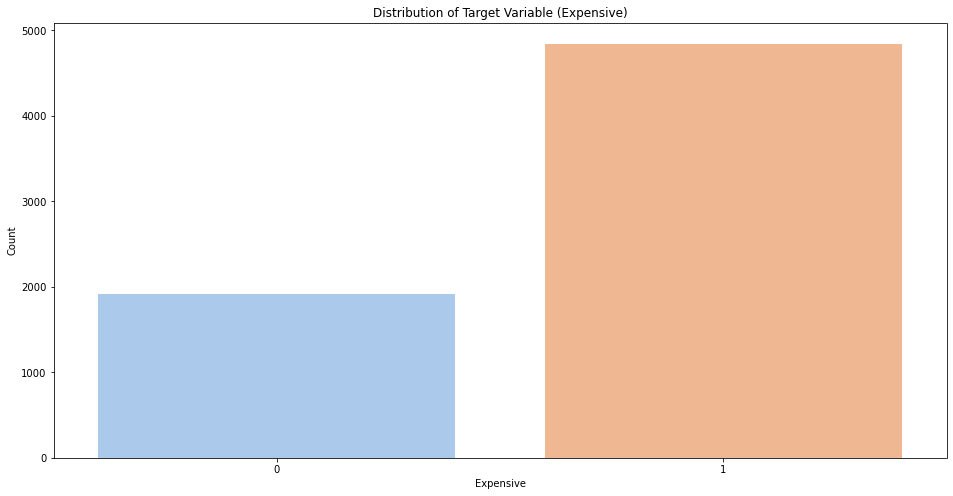

In [6]:
# Check the distribution of the target variable 'expensive' using seaborn
plt.figure(figsize=(16, 8))
sns.countplot(x='expensive', data=data, palette='pastel')
plt.xlabel('Expensive')
plt.ylabel('Count')
plt.title('Distribution of Target Variable (Expensive)')
plt.show() 


We can see that our target feature is unbalnced what can affect the model performance - we'll handle it later

### 2.2 Initial Qustions for the EDA


1. What is the relationship between the host response rate and the 'expensive' feature?

2. How does the number of amenities affect the 'expensive' feature?
3. What is the impact of the property type and room type on the 'expensive' feature?
4. Does the host being a superhost affect the 'expensive' feature?
5. How does the location (latitude and longitude) affect the 'expensive' feature?
6. What is the relationship between review scores and the 'expensive' feature?
7. What is the distribution of the host response time? 
8. How does the minimun/maximun night affect the 'expensive feature?
9. What are the features in the data the has high correlation between them?
10. Which binary variables affect the 'expensive' feature (instant_bookable)
12. In which columns we have missing values and what will be the best method to handle them?
14. How the licsense of the listing affect on the 'expensive feature?



### 2.3. Divide columns by types

In [7]:
binary_columns, categorical_columns, numerical_columns,_ = divide_columns_by_type(data,'expensive')
column_names = {
    'Binary': binary_columns,
    'Categorical': categorical_columns,
    'Numerical': numerical_columns
}
for col_type, col_names in column_names.items():
    print(f'{len(col_names)} {col_type} Columns: {col_names}')


5 Binary Columns: ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
12 Categorical Columns: ['host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_verifications', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'first_review', 'last_review', 'license']
36 Numerical Columns: ['id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_s

In [8]:
data[binary_columns].describe()

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable
count,6758,6759,6759,6759,6759
unique,2,2,2,2,2
top,f,t,t,t,t
freq,4974,6757,6285,6757,4464


In [9]:
data[categorical_columns].describe()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_verifications,property_type,room_type,bathrooms_text,amenities,first_review,last_review,license
count,6759,6164,6164,6276,6759,6759,6759,6732,6759,6175,6175,6755
unique,1290,4,33,57,7,52,4,35,5302,2012,877,4058
top,05/04/2020,within an hour,100%,100%,"['email', 'phone']",Entire rental unit,Entire home/apt,1 bath,"[""Essentials"", ""Refrigerator"", ""Dishes and sil...",01/01/2021,25/12/2022,Hotels and Inns Business Act | 台東区台東保健所 | 30台台...
freq,103,5423,4984,3143,5795,3487,4796,3752,99,27,189,88


In [10]:
data[numerical_columns].describe()

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,6759.000000,6.759000e+03,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6267.000000,6477.000000,6759.000000,...,6169.000000,6169.000000,6169.000000,6169.000000,6169.000000,6759.000000,6759.000000,6759.000000,6759.000000,6175.000000
mean,3380.000000,1.881663e+08,15.044829,22.584110,35.698990,139.734674,4.229176,1.477900,2.677783,2.886226,...,4.648779,4.791559,4.797538,4.681952,4.637217,12.395325,8.067170,2.223850,0.427726,1.031501
std,1951.299567,1.142974e+08,20.796970,33.227591,0.039322,0.075790,2.996842,1.231935,2.444584,15.872231,...,0.393358,0.282483,0.299521,0.309749,0.332595,15.650376,10.880906,4.959593,2.525644,1.142974
min,1.000000,7.716940e+05,1.000000,1.000000,35.540630,139.157320,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.020000
25%,1690.500000,7.173565e+07,4.000000,5.000000,35.688235,139.698795,2.000000,1.000000,1.000000,1.000000,...,4.520000,4.730000,4.750000,4.570000,4.530000,3.000000,1.000000,0.000000,0.000000,0.330000
50%,3380.000000,2.012103e+08,8.000000,11.000000,35.704020,139.728820,3.000000,1.000000,2.000000,1.000000,...,4.750000,4.870000,4.870000,4.750000,4.690000,7.000000,4.000000,0.000000,0.000000,0.740000
75%,5069.500000,2.877208e+08,18.000000,26.000000,35.720230,139.788160,6.000000,2.000000,3.000000,2.000000,...,4.900000,4.960000,4.970000,4.880000,4.830000,15.000000,12.000000,2.000000,0.000000,1.340000
max,6759.000000,4.609914e+08,168.000000,462.000000,35.830640,139.911580,16.000000,36.000000,50.000000,1000.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,98.000000,77.000000,32.000000,27.000000,24.030000


### 2.4. Relationship between the host response rate and the 'expensive' feature

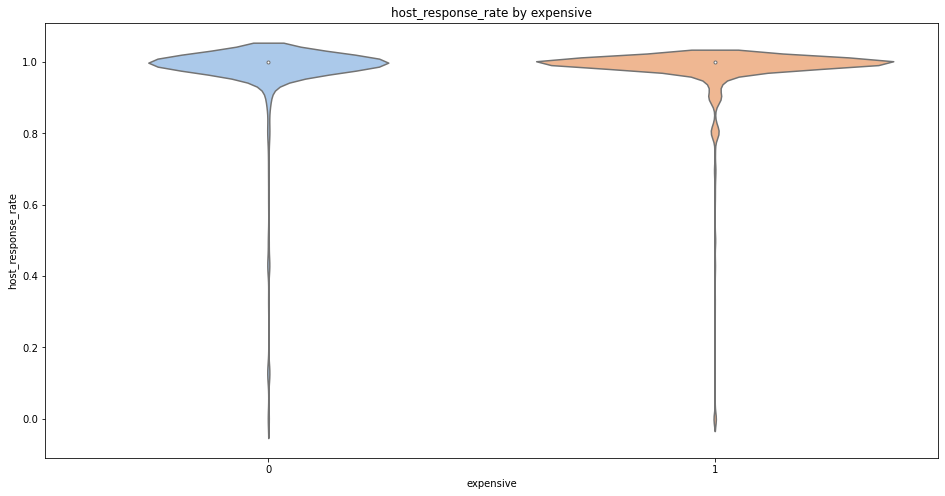

ANOVA statistic for host_response_rate vs expensive: 2.941928337924952
P-value: 0.08635348844657002
Accept null hypothesis: no difference in means


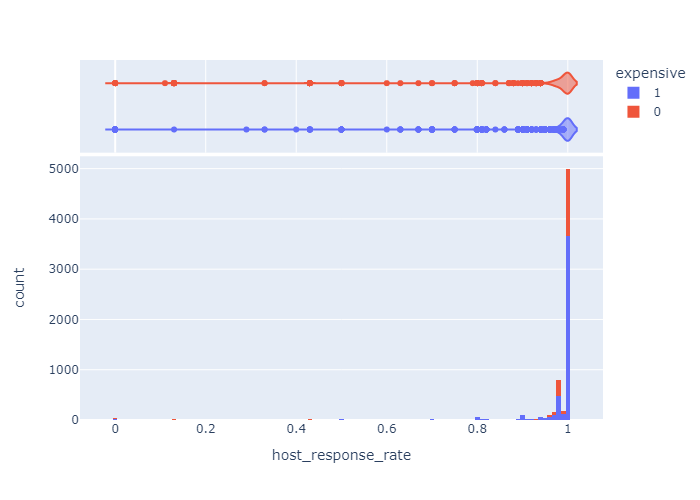

In [11]:

# Check if there are any values that contain '%' and convert to float
if data['host_response_rate'].dtype == object and data['host_response_rate'].str.contains('%').any():
    # Convert host_response_rate to a numerical value
    data['host_response_rate'] = data['host_response_rate'].str.rstrip('%').astype('float') / 100.0


# Plot the relationship between host_response_rate and expensive
plot_categorical_vs_numerical(data, 'expensive', 'host_response_rate', plot_kind='violin',palette = 'pastel')
data['host_response_rate'] = data['host_response_rate'].fillna(data['host_response_rate'].mean())
perform_anova(data, 'host_response_rate', 'expensive')

#plot histogram of host_response_rate using plotly express
fig = px.histogram(data, x="host_response_rate", color="expensive", marginal="violin", hover_data=data.columns)
fig.show()



In [12]:
# we can see that most of the values are 100% and the percentage of expensive is higher for 100% response rate
# lets check what is the correlation between host_response_rate and expensive

data['host_response_rate'].corr(data['expensive'])
print(data['host_response_rate'].corr(data['expensive']))

0.020861453407495185


low correlation 

### 2.5. Relationship between the num of amenities and the 'expensive' feature

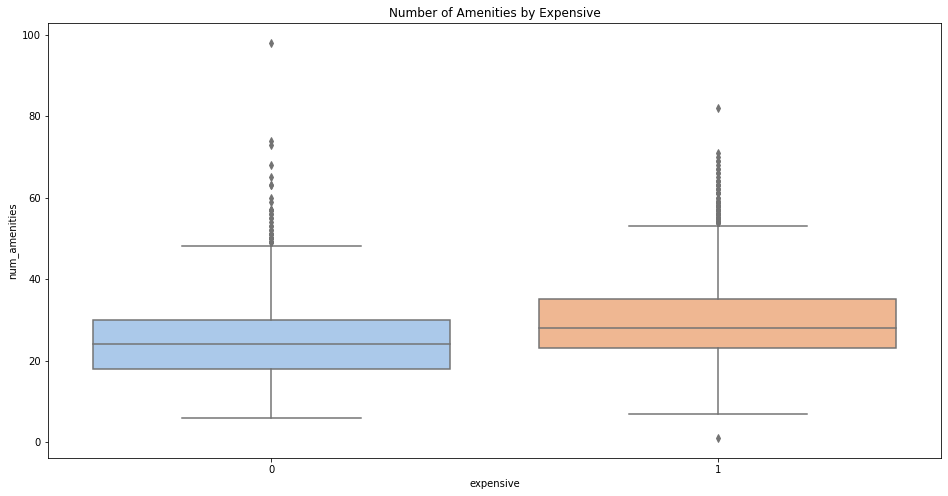

ANOVA statistic for num_amenities vs expensive: 225.0467915528334
P-value: 4.559015462232058e-50
Reject null hypothesis: there is a difference in means - means it can be used as good predictor for target variable


In [13]:
# Calculate the number of amenities
data['num_amenities'] = data['amenities'].str.split(',').apply(len)

# Plot the relationship between num_amenities and expensive 

plot_categorical_vs_numerical(data, 'expensive', 'num_amenities', plot_kind='box', title='Number of Amenities by Expensive',palette = 'pastel',figsize=(16,8))
perform_anova(data, 'num_amenities', 'expensive')

### 2.6. Distribution of the property and room time with respect to 'expensive' target

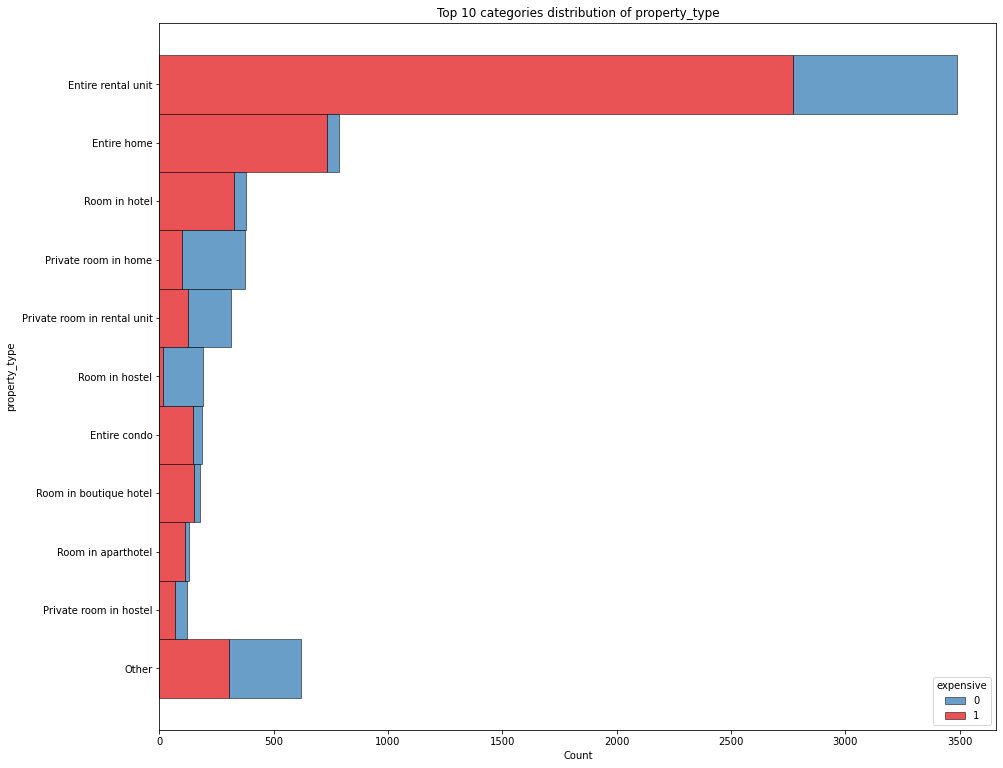

Chi-Square statistic for property_type vs expensive: 1835.0541220222715
P-value: 0.0
Reject null hypothesis: the variables is depedent - means it can be used as good predictor for target variable


True

In [14]:
# Check the distribution of the property type with expensive as hue 

palette = sns.color_palette("Set1", 2)[::-1]     
plot_top_categories_dist(data, 'property_type', 'expensive',palette=palette,top_n=10, figsize=(15, 13))
perform_chi2_test(data, 'property_type', 'expensive')

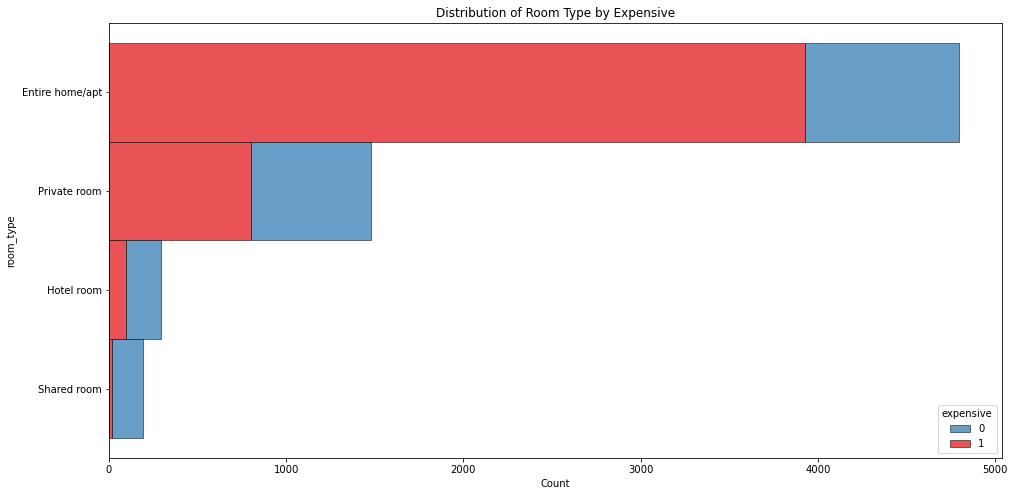

Chi-Square statistic for room_type vs expensive: 1041.458537540375
P-value: 1.825279887581665e-225
Reject null hypothesis: the variables is depedent - means it can be used as good predictor for target variable


True

In [15]:
# plot the distribution of room_type with expensive as hue using seaborn
plot_top_categories_dist(data, 'room_type', 'expensive',palette=palette,top_n=10,figsize=(16, 8),title='Distribution of Room Type by Expensive')
perform_chi2_test(data, 'room_type', 'expensive')

### 2.7. Does the host being a superhost affect the 'expensive' feature?

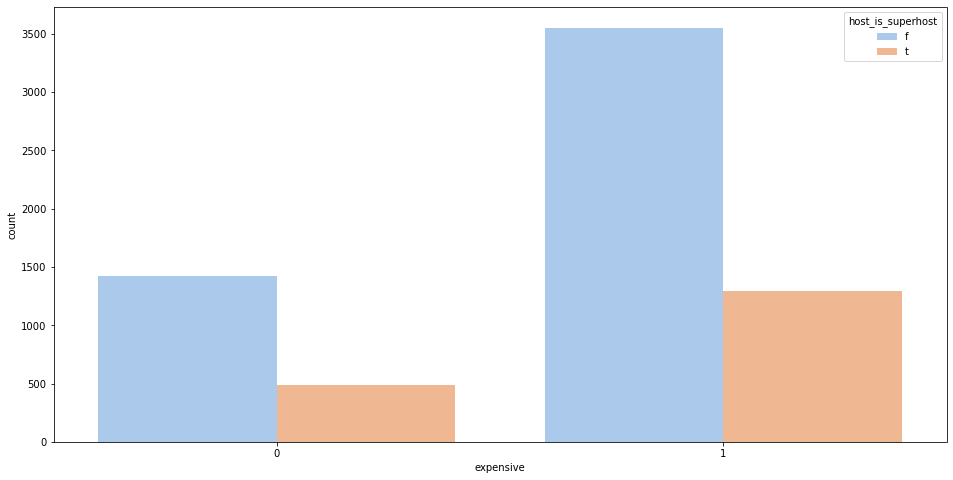

Chi-Square statistic for host_is_superhost vs expensive: 0.6576830644867122
P-value: 0.41737910221196806
Accept null hypothesis: the variables is independent


False

In [16]:
# does the host being superhost affect the price?
# set figsize to (16, 8)
plt.figure(figsize=(16, 8))
sns.countplot(x='expensive', hue='host_is_superhost', data=data, palette='pastel')
plt.show()


# perform chi2 test to check if there is a relationship between host_is_superhost and expensive
perform_chi2_test(data, 'host_is_superhost', 'expensive')

The host being superhost has no impact on the 'expensive' target

### 2.8. Relationship location and expensive target variable

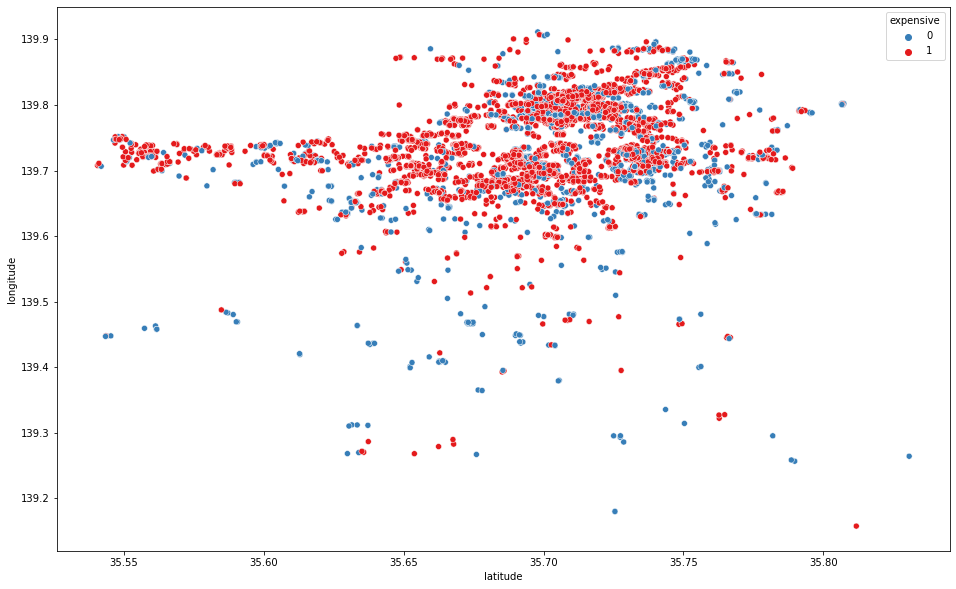

In [17]:
# How does the location affect the expensive feature ? # neighbourhood

plt.figure(figsize=(16, 10))
sns.scatterplot(x='latitude', y='longitude', hue='expensive', data=data, palette=palette)
plt.show()



From the scatter plot it appears that the 'expensive' properties are not clearly segregated by geographical coordinates, suggesting that latitude and longitude may not be strong predictors of property price in their raw form.
Lets try check if adding feature like 'city' using geograpical api will affect more on the 'expensive' targer variable 

In [18]:
from geopy.geocoders import Nominatim
from geopy import distance
from countryinfo import CountryInfo
data = pd.read_csv('data/train.csv')
num_rows = len(data)
counter = 0

geolocator = Nominatim(user_agent="MyApp")
capital_cache = {}

def get_location_by_coordinates(lat, lon):
    global counter
    location = geolocator.reverse([lat, lon], exactly_one=True,language='en')
    address = location.raw['address']
    city = address.get('city', '')
    country = address.get('country', '')
    capital = CountryInfo(country).capital()
    
    # Check if capital's coordinates exist in cache
    if capital not in capital_cache:
        capital_location = geolocator.geocode(capital)
        capital_cache[capital] = (capital_location.latitude,capital_location.longitude)

    distance_from_capital = distance.distance((lat, lon), capital_cache[capital]).km
    counter += 1
    print(f'{counter} from {num_rows}')
    return city, country, distance_from_capital

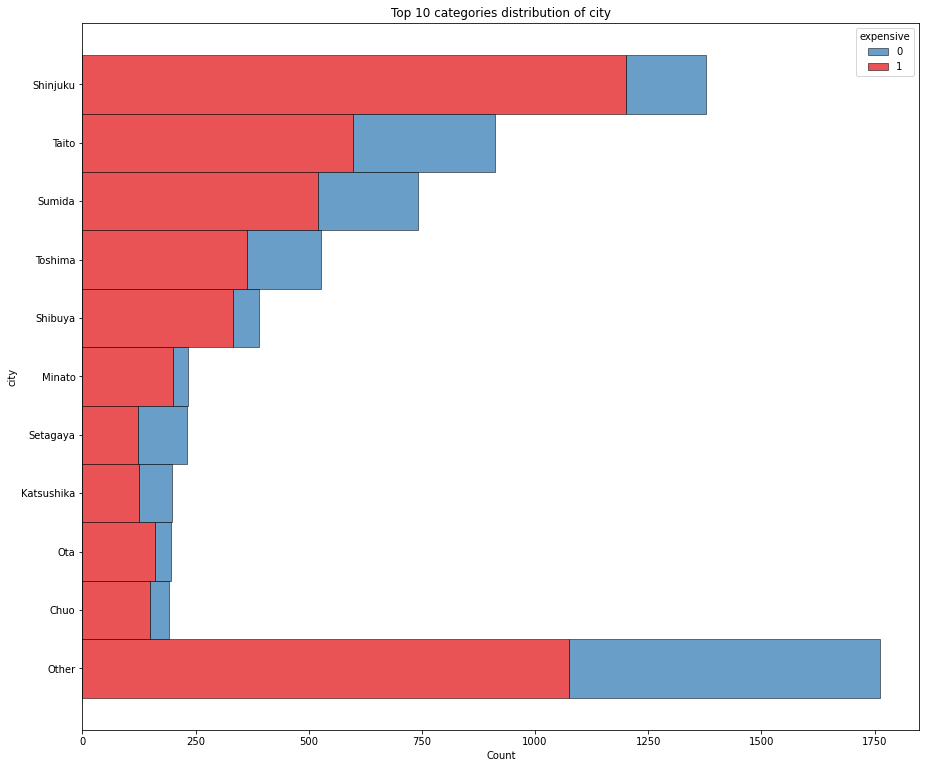

Chi-Square statistic for city vs expensive: 670.435741293076
P-value: 2.306048023338636e-112
Reject null hypothesis: the variables is depedent - means it can be used as good predictor for target variable


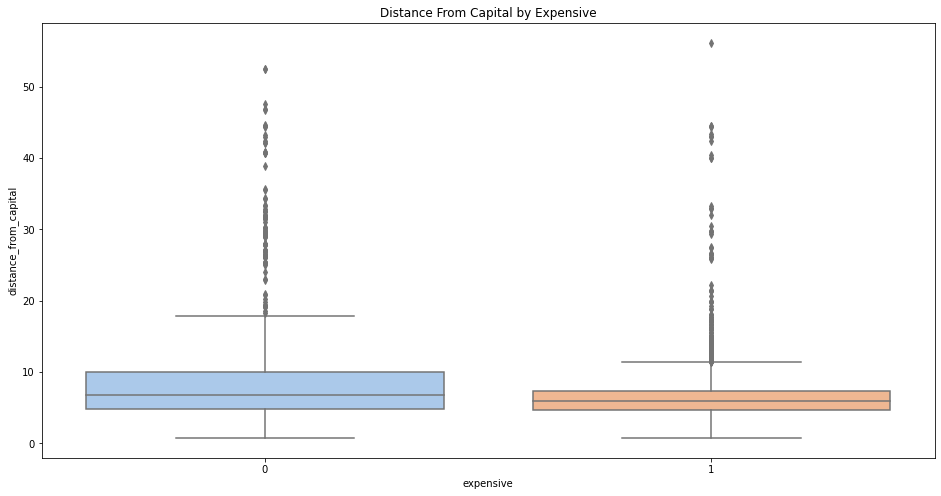

ANOVA statistic for distance_from_capital vs expensive: 274.2602815851794
P-value: 2.050912609423859e-60
Reject null hypothesis: there is a difference in means - means it can be used as good predictor for target variable


In [19]:
# data['city'], data['country'], data['distance_from_capital'] = zip(*data.apply(lambda row: get_location_by_coordinates(row['latitude'], row['longitude']), axis=1)) # i ran it once and save the data to csv 
data_with_location = pd.read_csv('data/train_data_new.csv')
plot_top_categories_dist(data_with_location, 'city', 'expensive',palette=palette,top_n=10, figsize=(15, 13))
perform_chi2_test(data_with_location, 'city', 'expensive')
plot_categorical_vs_numerical(data_with_location, 'expensive', 'distance_from_capital', plot_kind='box', title='Distance From Capital by Expensive',palette = 'pastel',figsize=(16,8))
perform_anova(data_with_location, 'distance_from_capital', 'expensive')

### 2.9. Relationship between the number of reviews and the 'expensive' variable

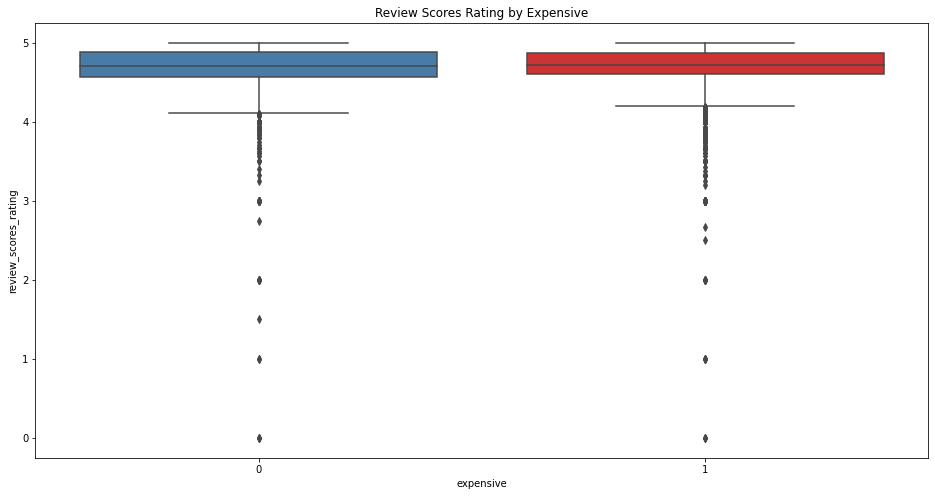

Chi-Square statistic for review_scores_rating vs expensive: 176.08386895483034
P-value: 0.010074311492187881
Reject null hypothesis: the variables is depedent - means it can be used as good predictor for target variable


True

In [20]:
# What is the relationship between the reviews_scores_rating and the 'expensive' variable?
data['review_scores_rating']
# fill missing values with mean value
data['review_scores_rating'] = data['review_scores_rating'].fillna(data['review_scores_rating'].mean())
plot_categorical_vs_numerical(data, 'expensive', 'review_scores_rating', plot_kind='box', figsize=(16, 8), title='Review Scores Rating by Expensive',palette = palette)
perform_chi2_test(data, 'review_scores_rating', 'expensive')

Text(0.5, 1.0, 'Number of Reviews vs Review Scores Rating')

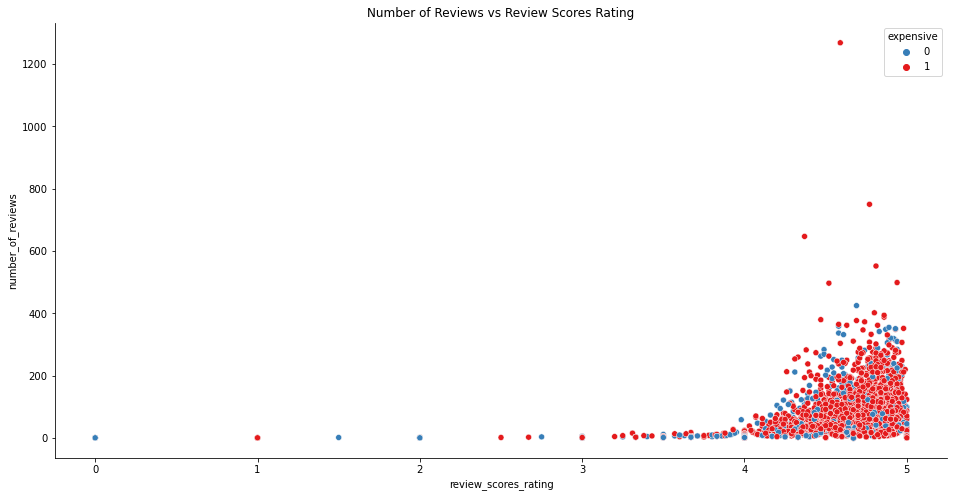

In [21]:
# scatter plot of number of reviews vs review_scores_rating
plt.figure(figsize=(16, 8))
sns.scatterplot(y='number_of_reviews', x='review_scores_rating', hue='expensive', data=data, palette=palette)
sns.despine()
plt.title('Number of Reviews vs Review Scores Rating')

ANOVA statistic for number_of_reviews vs expensive: 15.094939314064602
P-value: 0.00010321446834177642
Reject null hypothesis: there is a difference in means - means it can be used as good predictor for target variable


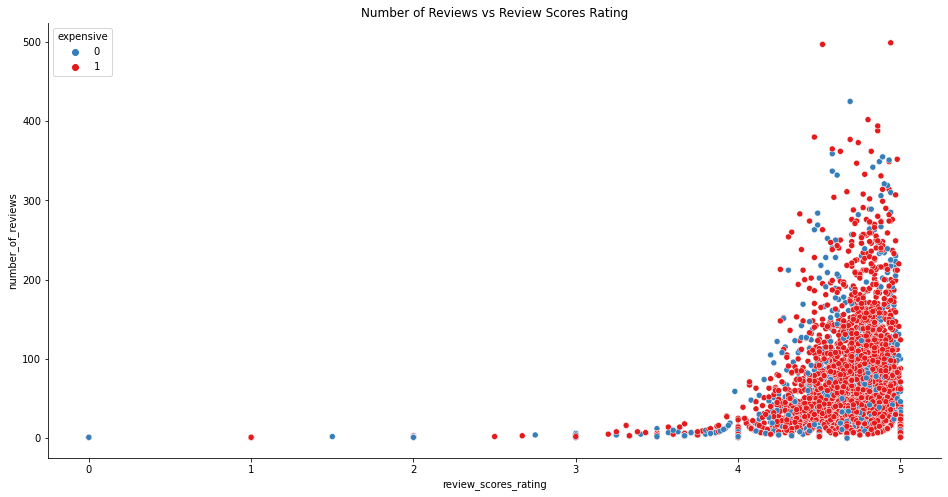

In [22]:
# remove outlier in number_of_reviews
data = data[data['number_of_reviews'] < 500]
plt.figure(figsize=(16, 8))
sns.scatterplot(y='number_of_reviews', x='review_scores_rating', hue='expensive', data=data, palette=palette)
sns.despine()
plt.title('Number of Reviews vs Review Scores Rating')
perform_anova(data, 'number_of_reviews', 'expensive')

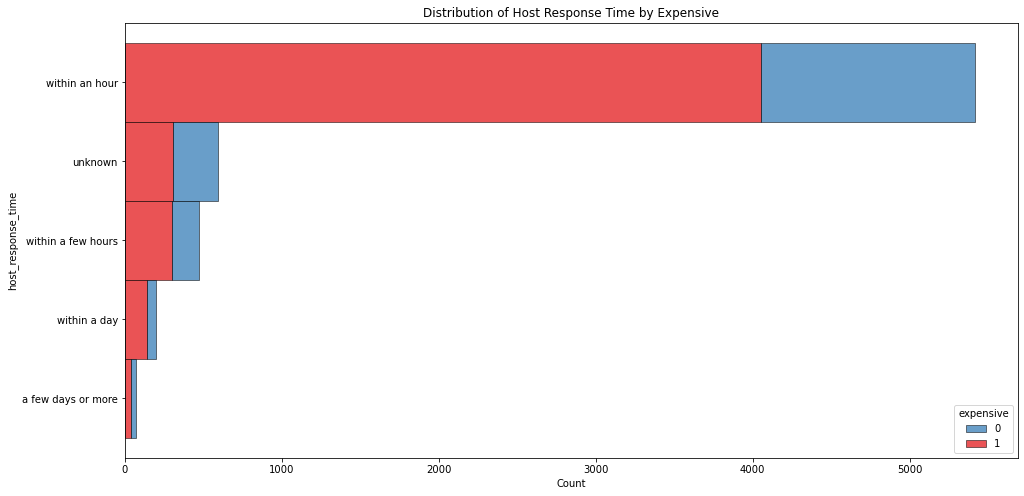

Chi-Square statistic for host_response_time vs expensive: 169.267677834164
P-value: 1.501883304917741e-35
Reject null hypothesis: the variables is depedent - means it can be used as good predictor for target variable


True

In [23]:
data['host_response_time'] = data['host_response_time'].fillna('unknown') 
# plot the distribution of host_response_time with expensive as hue using seaborn
plot_top_categories_dist(data, 'host_response_time', 'expensive',palette=palette,top_n=10,figsize=(16, 8),title='Distribution of Host Response Time by Expensive')
perform_chi2_test(data, 'host_response_time', 'expensive')

### 2.10. Relationship between the minimun\maximun number of night to 'expensive' target 

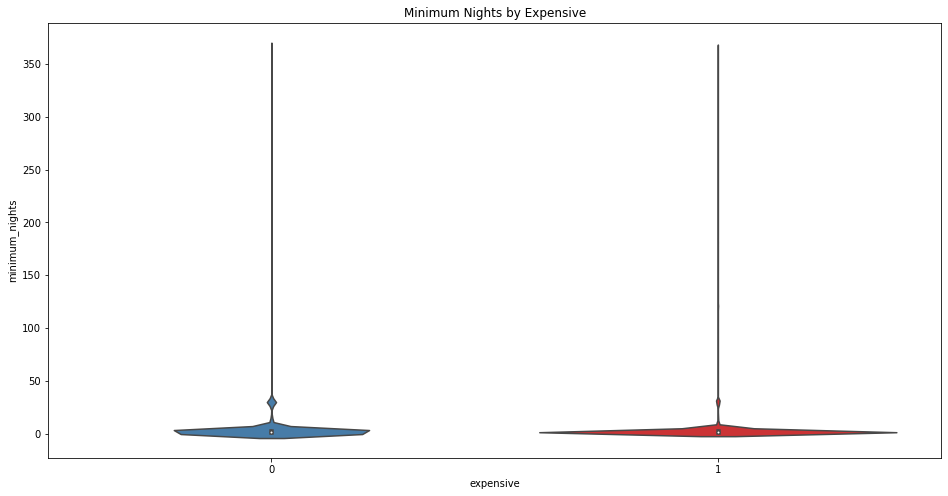

ANOVA statistic for minimum_nights vs expensive: 8.514684131507357
P-value: 0.0035345445779449438
Reject null hypothesis: there is a difference in means - means it can be used as good predictor for target variable


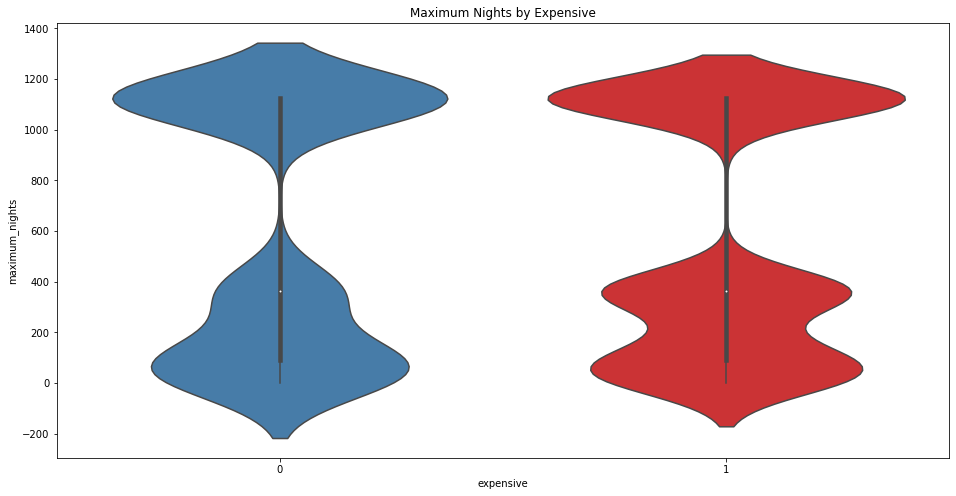

ANOVA statistic for maximum_nights vs expensive: 11.82999340998195
P-value: 0.0005863668127259126
Reject null hypothesis: there is a difference in means - means it can be used as good predictor for target variable
                minimum_nights  maximum_nights
minimum_nights        1.000000        0.025158
maximum_nights        0.025158        1.000000


In [24]:

# plot the distribution of minimum_nights with expensive as hue using seaborn

data = data[data['minimum_nights'] < 1000] # remove outliers in minimum_nights
plot_categorical_vs_numerical(data, 'expensive', 'minimum_nights', plot_kind='violin', figsize=(16, 8), title='Minimum Nights by Expensive',palette = palette)
perform_anova(data, 'minimum_nights', 'expensive')
plot_categorical_vs_numerical(data, 'expensive', 'maximum_nights', plot_kind='violin', figsize=(16, 8), title='Maximum Nights by Expensive',palette = palette)
perform_anova(data, 'maximum_nights', 'expensive')

# print correlation between minimum_nights and maximum_nights

print(data[['minimum_nights', 'maximum_nights']].corr()) # low correlation between the two variables so both can be used as good predictors

We can see that we have low correlation between the two variables both can be used as good predictors

### 2.11. Find numeric features that has high correlation between them

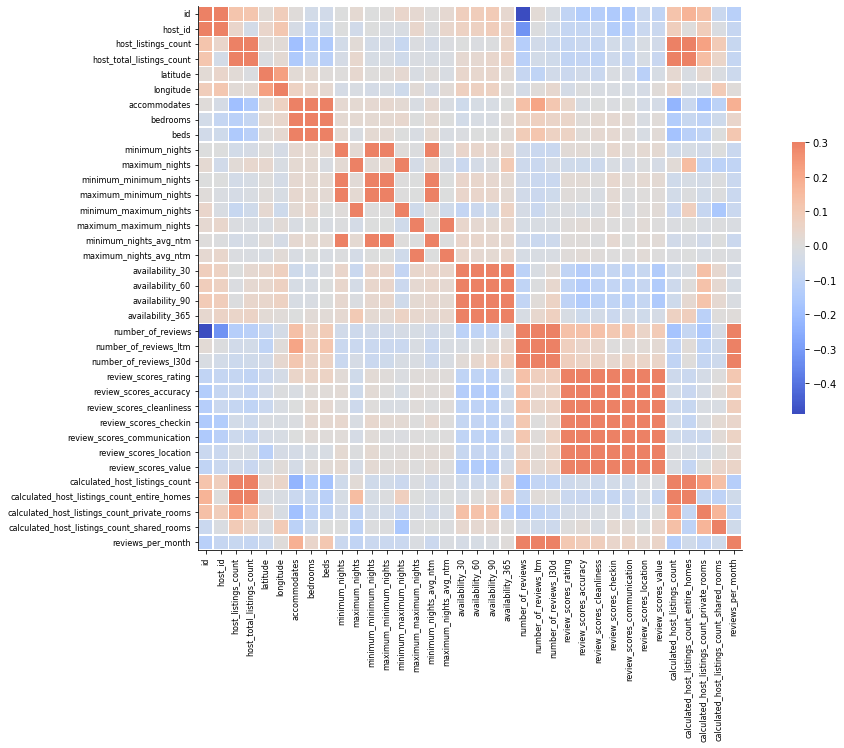

In [25]:
# Compute the correlation matrix

correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(18, 10))


# Plot a heatmap of the high correlations
g = sns.heatmap(correlation_matrix, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                fmt='.2f', cmap='coolwarm')

# Reduce the font size of the column names
g.set_xticklabels(g.get_xticklabels(), fontsize=8)
g.set_yticklabels(g.get_yticklabels(), fontsize=8)

sns.despine()
plt.show()


In [26]:
correlation_series  = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()

# Filter the series to include only correlations greater than 0.3
high_correlation = correlation_series[correlation_series > 0.3]

# Print the column names with high correlation
print(high_correlation[1:20])


maximum_nights_avg_ntm          maximum_maximum_nights       1.000000
minimum_nights                  minimum_minimum_nights       0.995624
minimum_nights_avg_ntm          maximum_minimum_nights       0.988878
availability_90                 availability_60              0.959696
minimum_nights_avg_ntm          minimum_nights               0.952546
minimum_minimum_nights          minimum_nights_avg_ntm       0.949419
availability_60                 availability_30              0.925392
minimum_nights                  maximum_minimum_nights       0.907922
minimum_minimum_nights          maximum_minimum_nights       0.904628
calculated_host_listings_count  host_listings_count          0.891974
availability_30                 availability_90              0.857694
reviews_per_month               number_of_reviews            0.815757
                                number_of_reviews_ltm        0.808261
host_listings_count             host_total_listings_count    0.800603
review_scores_accura

### 2.12. Visualize the relationship between diffrent numerical variables pairs that have high correlation

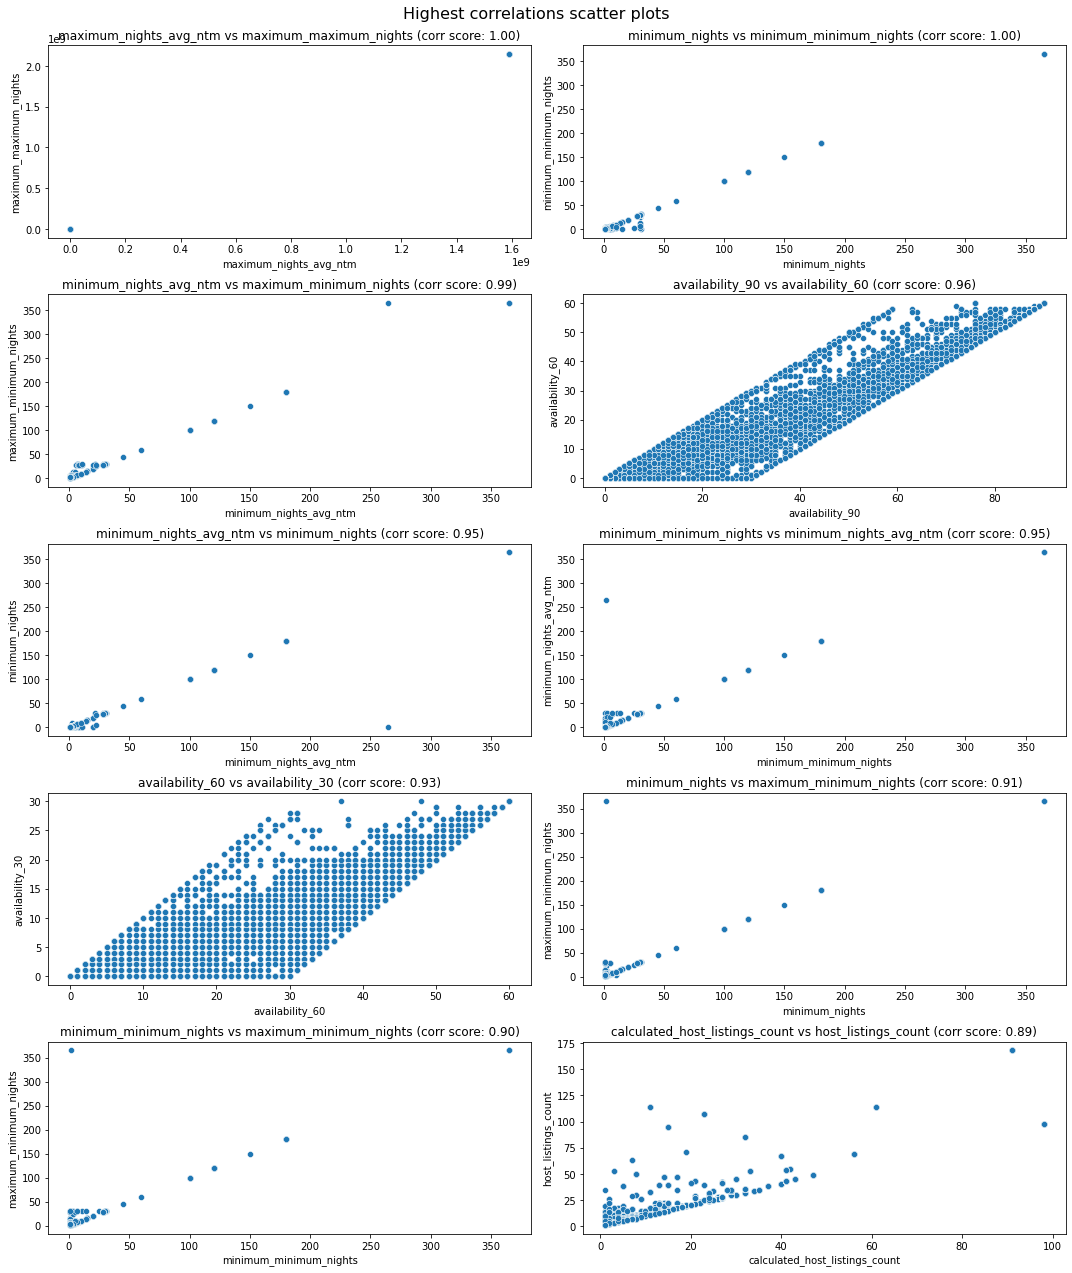

In [27]:

# Multi scatter plot function
def multi_scatter(featurs_tuples,data,n_col=2,title='Scatter Plots',figsize=(17, 20),cor_scores=None):
    n_rows = len(featurs_tuples)//n_col
    fig, axs = plt.subplots(n_rows, n_col, figsize=figsize)
    for i in range(n_rows):
        for j in range(n_col):
            sns.scatterplot(x=featurs_tuples[i*n_col+j][0], y=featurs_tuples[i*n_col+j][1], data=data, ax=axs[i, j])
            if cor_scores:
                axs[i, j].set_title(featurs_tuples[i*n_col+j][0]+' vs '+featurs_tuples[i*n_col+j][1]+ f' (corr score: {cor_scores[i*n_col+j]:.2f})')
            else:
                axs[i, j].set_title(featurs_tuples[i*n_col+j][0]+' vs '+featurs_tuples[i*n_col+j][1])
    plt.tight_layout()
    # set the title of the figure and adjust the padding between and around the subplots
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=0.95)

    plt.show()

featurs_tuples = list(high_correlation[1:12].index)
cor_scores = list(high_correlation[1:12].values)

multi_scatter(featurs_tuples,data,n_col=2,title='Highest correlations scatter plots',figsize=(15, 18),cor_scores=cor_scores)


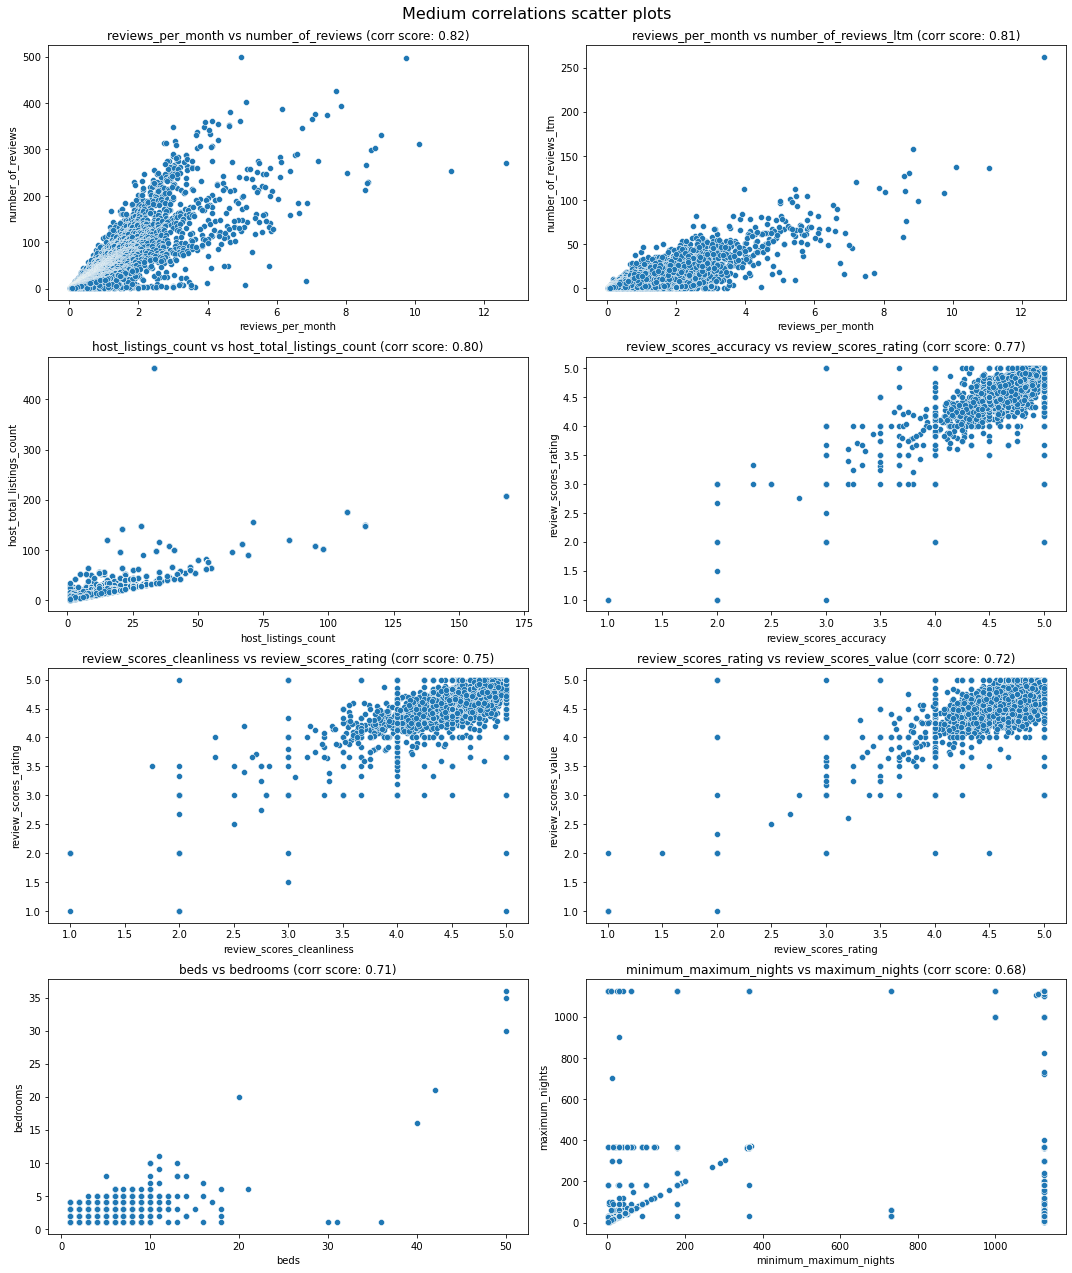

In [28]:
# medium correlations
featurs_tuples = list(high_correlation[12:20].index)
cor_scores = list(high_correlation[12:20].values)
multi_scatter(featurs_tuples,data,n_col=2,title='Medium correlations scatter plots',figsize=(15, 18),cor_scores=cor_scores)

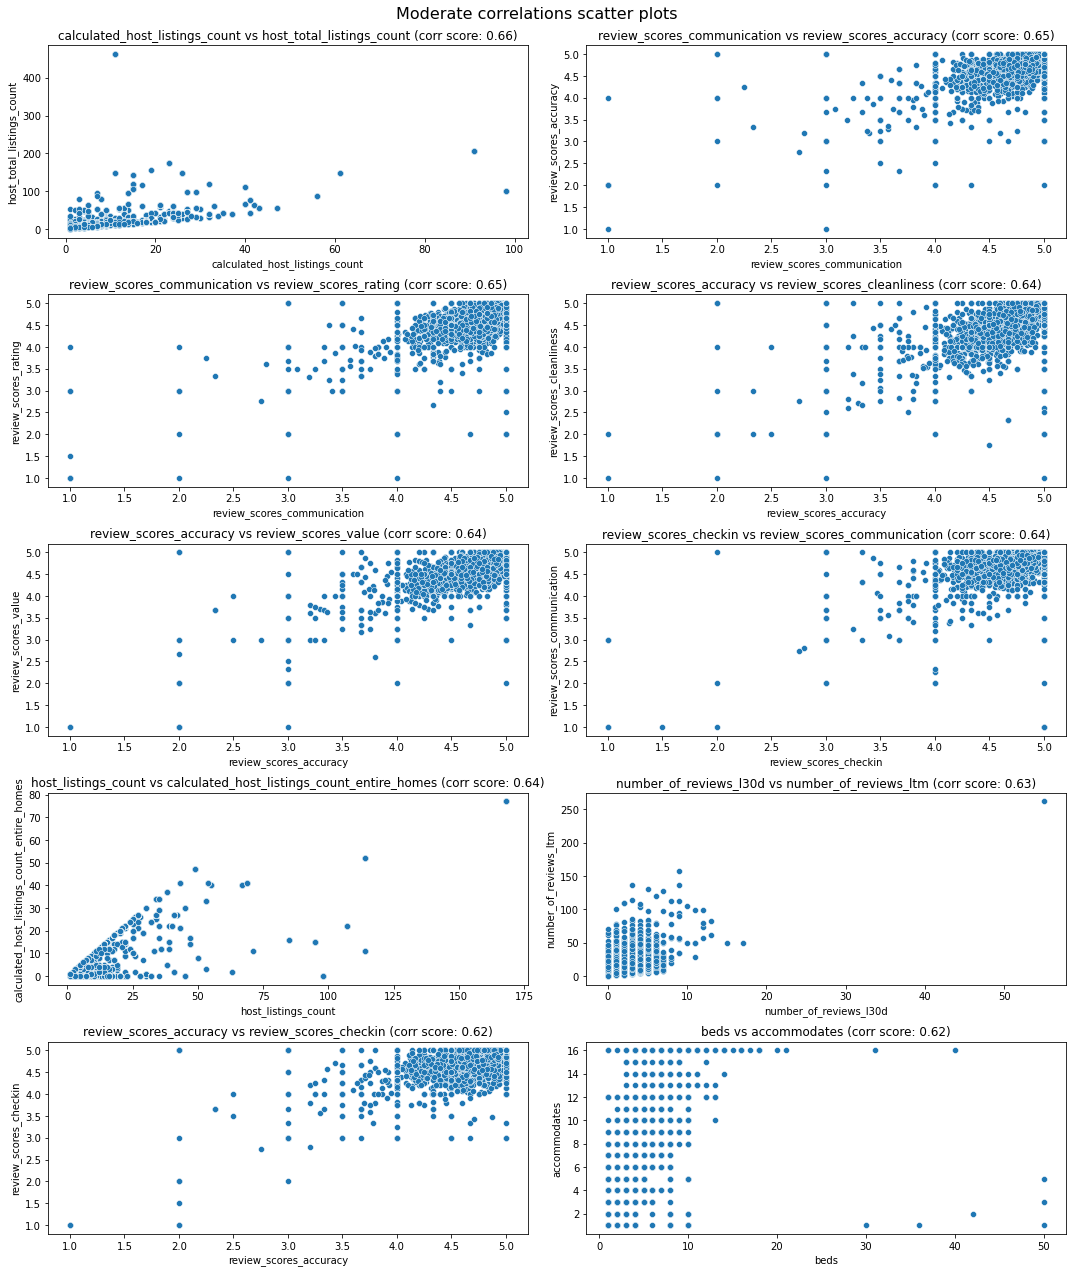

In [29]:
# Moderate correlations
featurs_tuples = list(high_correlation[20:30].index)
cor_scores = list(high_correlation[20:30].values)
multi_scatter(featurs_tuples,data,n_col=2,title='Moderate correlations scatter plots',figsize=(15, 18),cor_scores=cor_scores)

From the subplots we can see we have multiple pairs of numeric featurs with high correlation between them.

This can cause multicollinearity in our model so consider to use PCA to reduce the dimensions.

### 2.13 Find more binary features that can affect the target 'expensive'

In [30]:

if 'expensive' in binary_columns:
    binary_columns.remove('expensive')
# convert the binary columns to numeric (t = 1, f = 0)
# check if the binary columns are converted to numeric
if [np.int64] in data[binary_columns].dtypes.unique().tolist():
    data[binary_columns] = data[binary_columns].apply(lambda x: x.map({'t': 1, 'f': 0}))

for col in binary_columns:
    perform_chi2_test(data, col, 'expensive')
    print('\n')



Chi-Square statistic for host_is_superhost vs expensive: 0.5869669530029272
P-value: 0.4435943816784974
Accept null hypothesis: the variables is independent


Chi-Square statistic for host_has_profile_pic vs expensive: 0.0
P-value: 1.0
Accept null hypothesis: the variables is independent


Chi-Square statistic for host_identity_verified vs expensive: 0.843352860237108
P-value: 0.35843960847358747
Accept null hypothesis: the variables is independent


Chi-Square statistic for has_availability vs expensive: 0.0
P-value: 1.0
Accept null hypothesis: the variables is independent


Chi-Square statistic for instant_bookable vs expensive: 154.7056394474847
P-value: 1.6237567623241482e-35
Reject null hypothesis: the variables is depedent - means it can be used as good predictor for target variable




### 2.14. Liscense Distrbution and affect on 'expensive'

Number of unique diffrent license values:  4055
Top 10 license values:  license
Hotels and Inns Business Act | 台東区台東保健所 | 30台台健生環き第183号          88
Hotels and Inns Business Act | 新宿区保健所長   髙橋 　郁美 | 26新保衛環第12号     28
Hotels and Inns Business Act | 東京都新宿保健所 | 30新保衛環第213号            28
Hotels and Inns Business Act | 東京都中央区保健所 | 29 中保生還き　第157号        27
M130010735                                                       22
M130002186                                                       22
Hotels and Inns Business Act | 新宿区保健所 | 29新保衛環第193号              21
Hotels and Inns Business Act | 文京区文京保健所長　友松栄二 | 15文文生環き第503号     20
Hotels and Inns Business Act | 文京区文京保健所 | 文文生環き第5 0 1 号          19
M130002773                                                       19
Name: count, dtype: int64


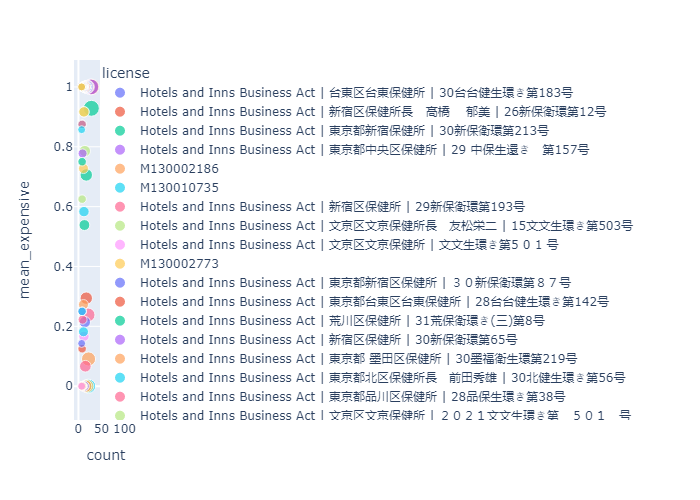

In [31]:


license_count = data['license'].value_counts() # count the number of each license value
print("Number of unique diffrent license values: ", len(license_count))

print("Top 10 license values: ", license_count[:10])

# plot the distribution of license with expensive as hue 
license_summary = data.groupby('license').agg({'expensive':['count', 'mean']}).reset_index()
license_summary.columns = ['license', 'count', 'mean_expensive']


# Select the top N licenses
N = 100
top_N_licenses = license_summary.nlargest(N, 'count')

fig = px.scatter(top_N_licenses, x='count', y='mean_expensive', color='license',
                 size='count', hover_data=['license'])
fig.show()



we can see that we have a lot of different unique values for license -

so it not clear how the license affects the on the 'expensive' variable - 

we consider to cluster the license values to groups and then check if the groups affect the 'expensive' variable

### 2.16  Find variables with Higehst correlation to 'expensive' feature

In [32]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import spearmanr

num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(exclude=[np.number]).columns

label_encoders = {}
data_copy = data.copy()
for col in cat_cols:
    le = LabelEncoder()
    data_copy[col] = le.fit_transform(data_copy[col])
    label_encoders[col] = le
    
correlation_data = []

for col in num_cols:
    if col != 'expensive':
        correlation, p_value = spearmanr(data_copy[col], data_copy['expensive'])
        correlation_data.append((col, correlation, p_value))

# Convert the list into a DataFrame and sort by absolute correlation
correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation', 'P-Value'])
correlation_df['Abs_Correlation'] = correlation_df['Correlation'].abs()
correlation_df = correlation_df.sort_values('Abs_Correlation', ascending=False)

# Display the correlation dataframe
correlation_df.head(10) # take top 10 features with highest correlation with expensive



,Column,Correlation,P-Value,Abs_Correlation
6,accommodates,0.437268,0.000000e+00,0.437268
32,calculated_host_listings_count_entire_homes,0.292766,1.368875e-133,0.292766
34,calculated_host_listings_count_shared_rooms,-0.245850,1.532729e-93,0.245850
19,availability_90,0.204893,6.212589e-65,0.204893
18,availability_60,0.192019,4.171961e-57,0.192019
17,availability_30,0.188544,4.367762e-55,0.188544
22,number_of_reviews_ltm,0.179137,8.141806e-50,0.179137
33,calculated_host_listings_count_private_rooms,-0.173340,1.039586e-46,0.173340
0,id,0.144613,6.867691e-33,0.144613
23,number_of_reviews_l30d,0.129283,1.442023e-26,0.129283


### Regression Equations created from each one the models 
1.  Simple Linear Regression with all features in the data
2.  Logistic Linear Regression with all features in the data
3.  Simple Linear Regression with top 10 correlated fetures to 'expensive
4.  Logistic Linear Regression with top 10 correlated fetures to 'expensive

In [33]:
# remove na in data_copy
data_copy = data_copy.dropna()
y_train = data_copy['expensive']
X_train = data_copy.drop(['expensive','id'], axis=1)

In [34]:
def print_equation(model, feature_names):
    max_chars_per_line = 80
    if isinstance(model, SimpleLinearRegression):
        eqn_str = "Y = {:.2f}".format(model.intercept)
        for i, c in enumerate(model.coeff):
            coeff_str = " + {:.2f}*{}".format(c, feature_names[i])
            if len(eqn_str + coeff_str) > max_chars_per_line:
                print(eqn_str)
                eqn_str = coeff_str.strip()
            else:
                eqn_str += coeff_str
    elif isinstance(model, myLogisticRegression):
        eqn_str = "logit(P(Y=1)) = {:.2f}".format(model.bias_)
        for i, w in enumerate(model.weights_):
            coeff_str = " + {:.2f}*{}".format(w, feature_names[i])
            if len(eqn_str + coeff_str) > max_chars_per_line:
                print(eqn_str)
                eqn_str = coeff_str.strip()
            else:
                eqn_str += coeff_str
    print(eqn_str)
    print('\n')


In [35]:
import warnings

# Ignore the specific warning
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [36]:

# Simple Linear Regression - using all data features
model_all_features = SimpleLinearRegression()
model_all_features.fit(X_train, y_train)
print("Simple Linear Regression with all features:")
print_equation(model_all_features, X_train.columns)

# Logistic Regression - using all data features
model_logistic_all = myLogisticRegression()
model_logistic_all.fit(X_train, y_train)
print("Logistic Regression with all features: ")
print_equation(model_logistic_all, X_train.columns)

# Simple Linear Regression - using top 10 correlated features
X_top = data_copy[correlation_df['Column'][:10].values]
model_top_10 = SimpleLinearRegression()
model_top_10.fit(X_top, y_train)
print("Simple Linear Regression with top 10 features: ")
print_equation(model_top_10, X_top.columns)

# Logistic Regression - using top 10 correlated features
model_logistic_top_10 = myLogisticRegression()
model_logistic_top_10.fit(X_top, y_train)

print("Logistic Regression with top 10 features: ")
print_equation(model_logistic_top_10, X_top.columns)

Simple Linear Regression with all features:
Y = 9.82 + 0.00*host_id + -0.00*host_since + 0.01*host_response_time
+ 0.00*host_response_rate + 0.00*host_acceptance_rate + 0.01*host_is_superhost
+ 0.00*host_listings_count + -0.00*host_total_listings_count
+ 0.00*host_verifications + -0.07*host_has_profile_pic
+ -0.01*host_identity_verified + -0.91*latitude + 0.16*longitude
+ 0.00*property_type + -0.16*room_type + 0.04*accommodates
+ -0.01*bathrooms_text + 0.02*bedrooms + -0.01*beds + 0.00*amenities
+ 0.00*minimum_nights + -0.00*maximum_nights + -0.00*minimum_minimum_nights
+ 0.00*maximum_minimum_nights + -0.00*minimum_maximum_nights
+ 0.00*maximum_maximum_nights + -0.00*minimum_nights_avg_ntm
+ -0.00*maximum_nights_avg_ntm + 0.25*has_availability + 0.00*availability_30
+ -0.00*availability_60 + 0.00*availability_90 + 0.00*availability_365
+ -0.00*number_of_reviews + -0.00*number_of_reviews_ltm
+ -0.00*number_of_reviews_l30d + 0.00*first_review + -0.00*last_review
+ 0.10*review_scores_rati

Logistic Regression with all features: 
logit(P(Y=1)) = -0.02 + 20106.40*host_id + -24.10*host_since
+ -0.01*host_response_time + -0.66*host_response_rate
+ -0.89*host_acceptance_rate + 0.00*host_is_superhost
+ -0.27*host_listings_count + -0.21*host_total_listings_count
+ -0.01*host_verifications + -0.02*host_has_profile_pic
+ -0.02*host_identity_verified + -0.76*latitude + -2.99*longitude
+ -1.97*property_type + -0.17*room_type + 0.41*accommodates
+ -0.33*bathrooms_text + 0.06*bedrooms + 0.11*beds + -49.86*amenities
+ -0.24*minimum_nights + -18.08*maximum_nights + -0.24*minimum_minimum_nights
+ -0.17*maximum_minimum_nights + -27.00*minimum_maximum_nights
+ 5091.16*maximum_maximum_nights + -0.20*minimum_nights_avg_ntm
+ 3759.07*maximum_nights_avg_ntm + -0.02*has_availability + 0.25*availability_30
+ 0.72*availability_60 + 1.36*availability_90 + 2.95*availability_365
+ 0.24*number_of_reviews + 0.79*number_of_reviews_ltm
+ 0.06*number_of_reviews_l30d + -18.40*first_review + -6.38*last_re

From the equations above we get the following insights:
1.  Focusing on the top correlated features provide more interpretable model where accomodates feature with the top correlation have highest impact on the result
2.  Features like 'host_id' and 'latitude' show high influence in the logistic regression model, but they don't provide intuitive insights 
3.  Features like  'maximum_maximum_nights' and 'maximum_nights_avg_ntm' has extreme impact on the model comparing to others features - well need to normelized this features


### 2.17 Present the new axis created from PCA on all features 

#### Scree_Plot- first we plot scree plot when taking all the top correlated features in the model:

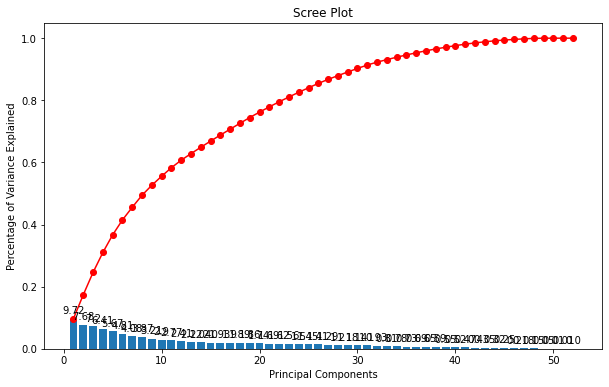

In [37]:
pca_2d = PCA(n_components=2) 
pca_2d.fit(X_train)
pca_2d.plot_scree()

We can see that two first componet only define less than 20% variation of the data - we consider to choose only the top correlated features in our data and do pca just with them

#### PCA k=2

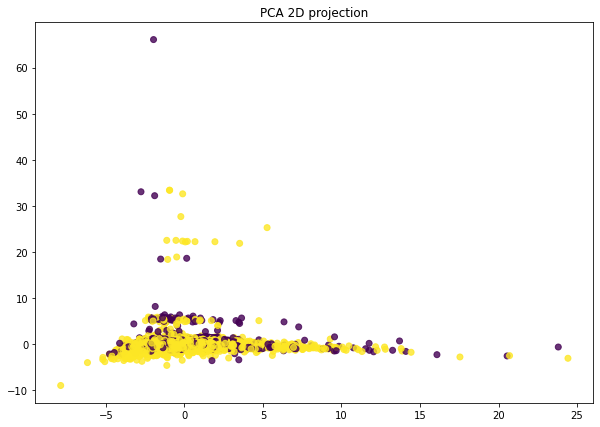

In [38]:
X_train_2d = pca_2d.transform(X_train)

# 2D PCA projection plot
plt.figure(figsize=(10, 7))
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, alpha=0.8)
plt.title('PCA 2D projection')
plt.show()

#### PCA k=3

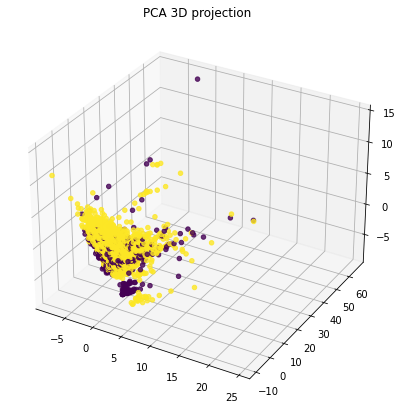

In [39]:
pca_3d = PCA(n_components=3) 
pca_3d.fit(X_train)
X_train_3d = pca_3d.transform(X_train)

# 3D PCA projection plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
ax.scatter3D(X_train_3d[:, 0], X_train_3d[:, 1], X_train_3d[:, 2], c=y_train, alpha=0.8)
plt.title('PCA 3D projection')
plt.show()

# 3. Preprocessing the data 

In [40]:

# read the data again
data = pd.read_csv('data/train.csv')
data[binary_columns] = data[binary_columns].apply(lambda x: x.map({'t': 1, 'f': 0}))

# convert to numeric each columns with '%' in its values if needed

data['host_response_rate'] = data['host_response_rate'].str.replace('%', '').astype(float)

data['host_acceptance_rate'] = data['host_acceptance_rate'].str.replace('%', '').astype(float)


binary_columns, categorical_columns, numerical_columns,_ = divide_columns_by_type(data,'expensive')

column_names = {
    'Binary': binary_columns,
    'Categorical': categorical_columns,
    'Numerical': numerical_columns
}
for col_type, col_names in column_names.items():
    print(f'{len(col_names)} {col_type} Columns: {col_names}')



5 Binary Columns: ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
10 Categorical Columns: ['host_since', 'host_response_time', 'host_verifications', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'first_review', 'last_review', 'license']
38 Numerical Columns: ['id', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_s

### 3.1. Handle outliers in the data

In [41]:
from scipy.stats import skew
numerical_features = [col_name for col_name in numerical_columns if col_name not in ['id', 'expensive','host_id', 'latitude', 'longitude']]
extreme_data = []

for n_col in numerical_features:
    extreme_outliers = data[n_col].quantile(0.99)
    extreme_data.append({'Feature': n_col, 'mean': int(data[n_col].mean()),'min':int(data[n_col].min()), 'max':int(data[n_col].max()), 'median': int(data[n_col].median()), '0.99 quantile': extreme_outliers})

extreme_df = pd.DataFrame(extreme_data, columns=['Feature', 'mean', 'median','max','min', '0.99 quantile'])
# plot the extreme_df in order to see the difference between mean, median and 0.99 quantile
display(extreme_df)


,Feature,mean,median,max,min,0.99 quantile
0,host_response_rate,97,100,100,0,100.000
1,host_acceptance_rate,95,100,100,0,100.000
2,host_listings_count,15,8,168,1,98.000
3,host_total_listings_count,22,11,462,1,148.000
4,accommodates,4,3,16,0,16.000
5,bedrooms,1,1,36,1,5.000
6,beds,2,2,50,1,10.000
7,minimum_nights,2,1,1000,1,30.000
8,maximum_nights,566,365,1125,1,1125.000
9,minimum_minimum_nights,2,1,1000,1,30.000


In [42]:

# ---------------------- Remove extreme values  ---------------------- # 

features_with_extreme_values_to_remove = ['minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm']
original_data_shape = data.shape
for feature in features_with_extreme_values_to_remove:
    cap_value = extreme_df[extreme_df['Feature'] == feature]['0.99 quantile'].values[0]
    print(f"Cap value for {feature} is {cap_value}")
    data = data[data[feature]  <= cap_value]
    # print number of outliers that were removed
    print(f"Number of outliers in {feature} that were trimmed: {original_data_shape[0] - data.shape[0]}")
    

Cap value for minimum_nights is 30.0
Number of outliers in minimum_nights that were trimmed: 30
Cap value for maximum_nights is 1125.0
Number of outliers in maximum_nights that were trimmed: 30
Cap value for minimum_minimum_nights is 30.0
Number of outliers in minimum_minimum_nights that were trimmed: 31
Cap value for maximum_minimum_nights is 30.0
Number of outliers in maximum_minimum_nights that were trimmed: 32
Cap value for minimum_maximum_nights is 1125.0
Number of outliers in minimum_maximum_nights that were trimmed: 32
Cap value for maximum_maximum_nights is 1125.0
Number of outliers in maximum_maximum_nights that were trimmed: 39
Cap value for minimum_nights_avg_ntm is 30.0
Number of outliers in minimum_nights_avg_ntm that were trimmed: 39
Cap value for maximum_nights_avg_ntm is 1125.0
Number of outliers in maximum_nights_avg_ntm that were trimmed: 39


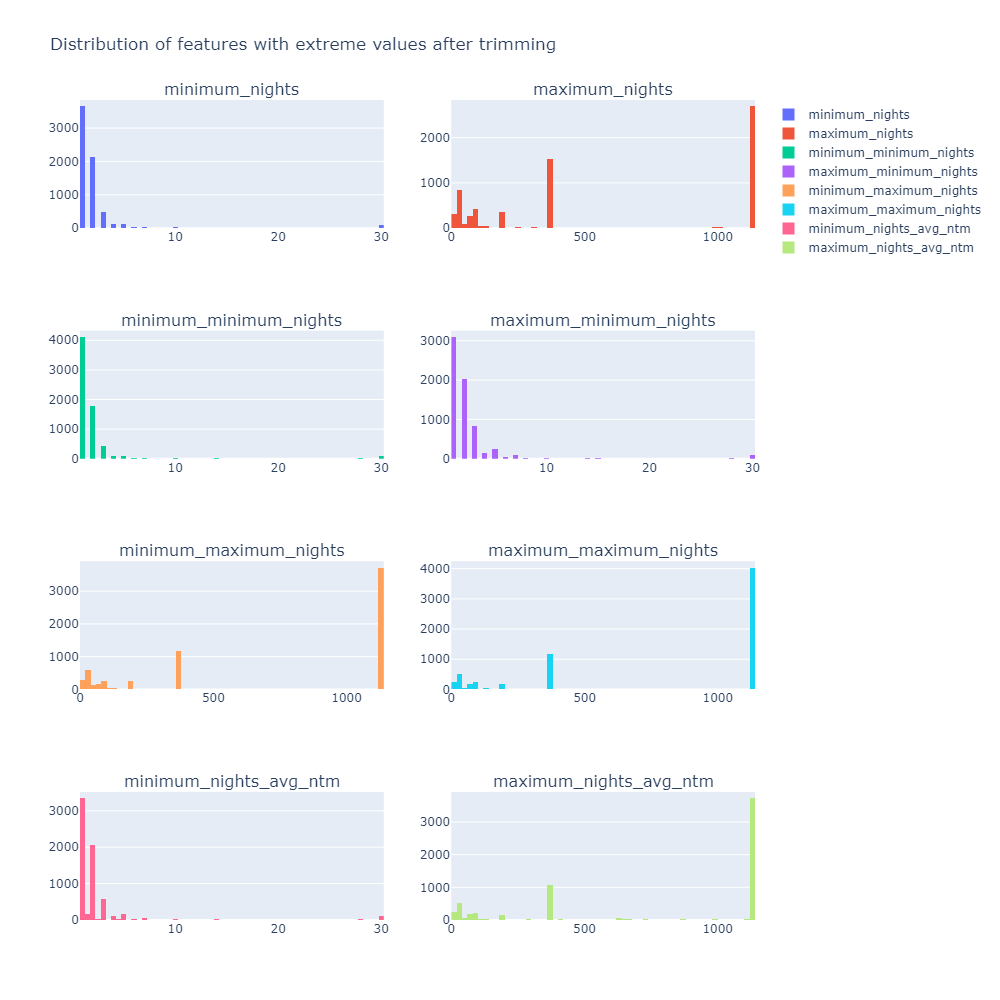

In [43]:

def multi_histogram(data, cols, cols_per_row=2,title = 'Histograms',figsize=(None, None),nbins=None):
    num_cols = len(cols)
    num_rows = num_cols // cols_per_row if num_cols % cols_per_row == 0 else num_cols // cols_per_row + 1
    
    if figsize == (None, None):
        height , width = 250*num_rows, 1000
    else:
        height, width = figsize


    fig = make_subplots(rows=num_rows, cols=cols_per_row, subplot_titles=cols)

    for i, col in enumerate(cols):
        if nbins is None:
            nbins_value = int(np.sqrt(len(data[col])))
        else:
            nbins_value = nbins
        fig.add_trace(go.Histogram(x=data[col], name=col, nbinsx=nbins_value), row=i//cols_per_row + 1, col=i%cols_per_row + 1)
        
    fig.update_layout(height=height, width=width, title_text=title)
    fig.show()
    

multi_histogram(data, features_with_extreme_values_to_remove, cols_per_row=2,title = 'Distribution of features with extreme values after trimming')

still data is skewed, so we'll consider use tranformation to make it in normal distrbution

## 3.2. Handle missing values

In [44]:
# print the number of missing values in each column
missing_values = data.isnull().sum()
total_values_in_column = data.shape[0]
# Create a DataFrame with the missing values information
missing_values_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})
missing_values_df = missing_values_df.sort_values('Missing Values', ascending=False)
# show only >0 missing values
missing_values_df = missing_values_df[missing_values_df['Missing Values'] > 0]
print(missing_values_df) 

                         Column  Missing Values
40       review_scores_accuracy             582
45          review_scores_value             581
41    review_scores_cleanliness             581
42        review_scores_checkin             581
44       review_scores_location             581
43  review_scores_communication             581
4            host_response_rate             576
3            host_response_time             576
39         review_scores_rating             575
38                  last_review             575
52            reviews_per_month             575
37                 first_review             575
18                     bedrooms             489
5          host_acceptance_rate             466
19                         beds             279
17               bathrooms_text              27
46                      license               4
6             host_is_superhost               1


-  #### Method 1:  Fill Missing values by host_id group by
    we lookup what is the host id value of each listing with null value for this columns: ['host_response_rate', 'host_acceptance_rate', 'license']
    
    if this host id has more listings well take his mean value or the mode value (in the case of 'license' column)
    if the host id with the missing value dont have more listings well take the genreal mean value 

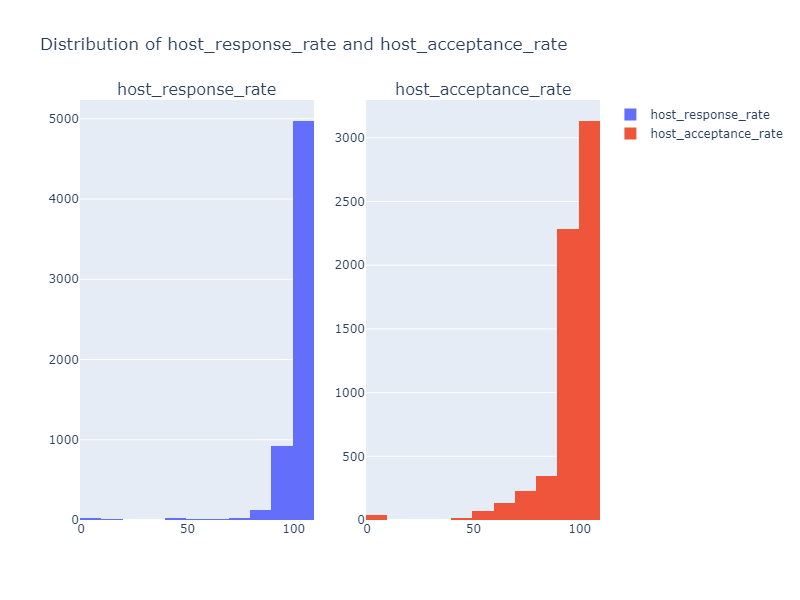

In [45]:
multi_histogram(data, ['host_response_rate', 'host_acceptance_rate'], cols_per_row=2,title = 'Distribution of host_response_rate and host_acceptance_rate',figsize=(600, 800), nbins=20)

We can see that the distribution of both columns is very similar, so we can fill the missing values with the mean of the column


In [46]:
host_cols = ['host_response_rate', 'host_acceptance_rate', 'license']


# General mean and mode for each column
mean_host_response_rate = data['host_response_rate'].mean()
mean_host_acceptance_rate = data['host_acceptance_rate'].mean()
mode_license = data['license'].mode()[0]

general_values = {
    'host_response_rate': mean_host_response_rate,
    'host_acceptance_rate': mean_host_acceptance_rate,
    'license': mode_license
}

# find the host_ids that has na values for col and fill with thir mean or mode value 
for col in host_cols:
    # find the host_ids that has na values for col
    host_ids_na = data[data[col].isnull()]['host_id'].unique()
    pre_impute_count = data[data[col].isnull()].shape[0]
    print(f'Number of missing values in {col} before imputation: {pre_impute_count}')
    count = 0
    for host_id in host_ids_na:
        # if col == license fill with mode, else fill with mean
        if col == 'license':
            mode_val = data[(data['host_id'] == host_id) & (data[col].notnull())][col].mode()
            if mode_val.empty:
                count += 1
            fill_val = mode_val[0] if not mode_val.empty else general_values[col]
        else:
            mean_val = data[(data['host_id'] == host_id) & (data[col].notnull())][col].mean()
            if np.isnan(mean_val):
                count += 1
            fill_val = mean_val if not np.isnan(mean_val) else general_values[col]
        
        # fill the missing values
        data.loc[(data['host_id'] == host_id) & (data[col].isnull()), col] = fill_val

    if col == 'license':
        print(f"Number of missing values in {col} filled with mode: {pre_impute_count - count}")
        print(f"Number of missing values in {col} that couldn't be filled with mode: {count}")
    else:
        print(f"Number of missing values in {col} filled with mean: {pre_impute_count - count}")
        print(f"Number of missing values in {col} that couldn't be filled with mean: {count}")
        


Number of missing values in host_response_rate before imputation: 576


Number of missing values in host_response_rate filled with mean: 394
Number of missing values in host_response_rate that couldn't be filled with mean: 182
Number of missing values in host_acceptance_rate before imputation: 466
Number of missing values in host_acceptance_rate filled with mean: 311
Number of missing values in host_acceptance_rate that couldn't be filled with mean: 155
Number of missing values in license before imputation: 4
Number of missing values in license filled with mode: 3
Number of missing values in license that couldn't be filled with mode: 1


-  ####  Method 2: Use mice algorithm
    Well take the missing values that has high correlation with each other and apply mice algorithm that use multivariable linear regression in order to predict the missing value

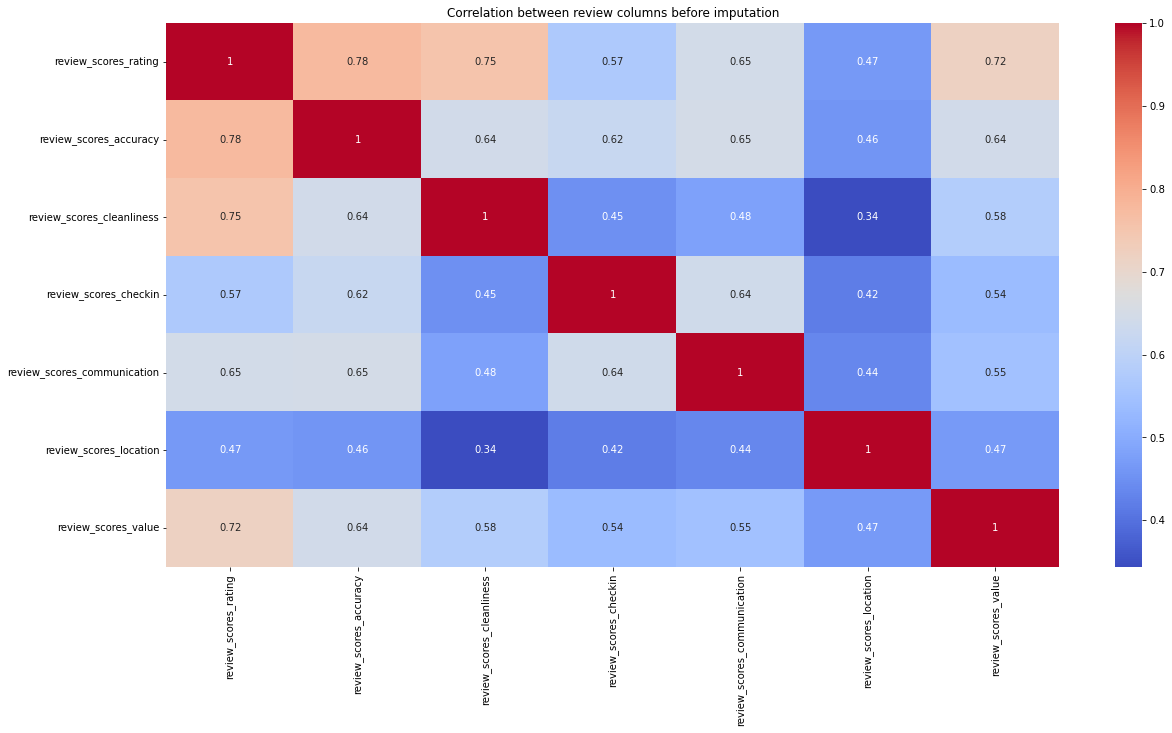

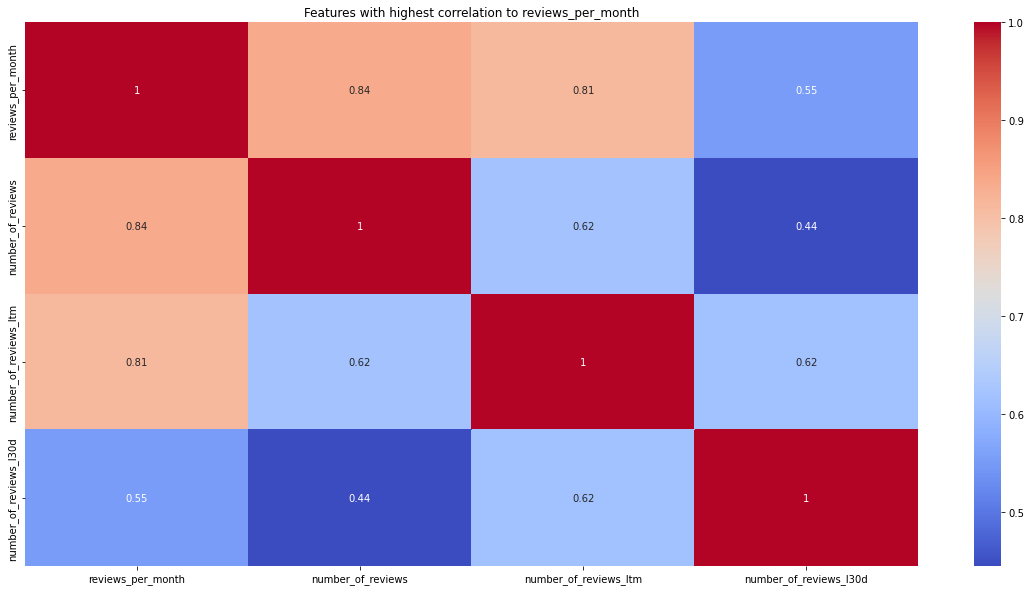

In [47]:
# 1. Use mice algorithm to impute missing of features that have linear relationship with each other

review_cols_for_mice = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                         'review_scores_value']
plot_heatmap(data, review_cols_for_mice,title='Correlation between review columns before imputation')


reviews_per_month_for_mice = plot_highest_correlation(data, numerical_columns, 'reviews_per_month', 3)
reviews_per_month_for_mice = ['reviews_per_month','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d']


We can see that reviews_per_month has the highest correlation with number_of_reviews_ltm, number_of_reviews and number_of_reviews_l30d so we will use these 3 features for the mice imputation

Also, we can see that review_scores_rating has the highest correlation with
review_scores_value, review_scores_location, review_scores_cleanliness, review_scores_accuracy, review_scores_checkin and review_scores_communication so we will use these 6 features for the mice imputation

In [48]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def impute_missing_values_mice(data, columns, random_state=2023, max_iter=20):
    # Define imputer
    imputer = IterativeImputer(random_state=random_state, max_iter=max_iter)
    
    # Fit on the dataset
    imputer.fit(data.loc[:, columns])
    
    # Transform the dataset
    data[columns] = imputer.transform(data[columns])

    return data
# ---------------------- Impute missing values ---------------------- #

data = impute_missing_values_mice(data, review_cols_for_mice, random_state=2023, max_iter=20)

data = impute_missing_values_mice(data, reviews_per_month_for_mice, random_state=2023, max_iter=20)



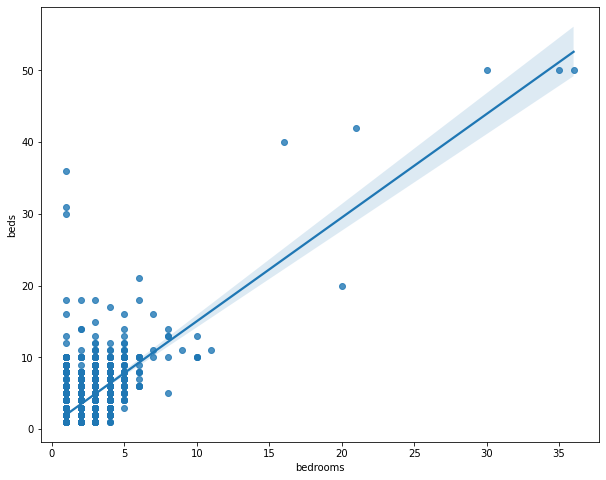

In [49]:
# show regression line between bedrooms and beds
plt.figure(figsize=(10, 8))
# plt.title('Regression line between beds and bedrooms')
sns.regplot(x='bedrooms', y='beds', data=data)

data = impute_missing_values_mice(data, ['bedrooms', 'beds'], random_state=2023, max_iter=20)

-  ####  Handle missing dates values - Use max for last_review and MCAR for first review

In [50]:
def random_imputation(data, feature):
    number_of_missing_values = data[feature].isnull().sum()
    
    if number_of_missing_values > 0:
        # Generate random values from the non-missing values of 'feature'
        random_sample = data[feature].dropna().sample(number_of_missing_values, random_state=0)
        
        # pandas needs to have the same index in order to merge datasets
        random_sample.index = data[data[feature].isnull()].index
        
        # Replace the missing values with the random sample
        data.loc[data[feature].isnull(), feature] = random_sample
        
    return data


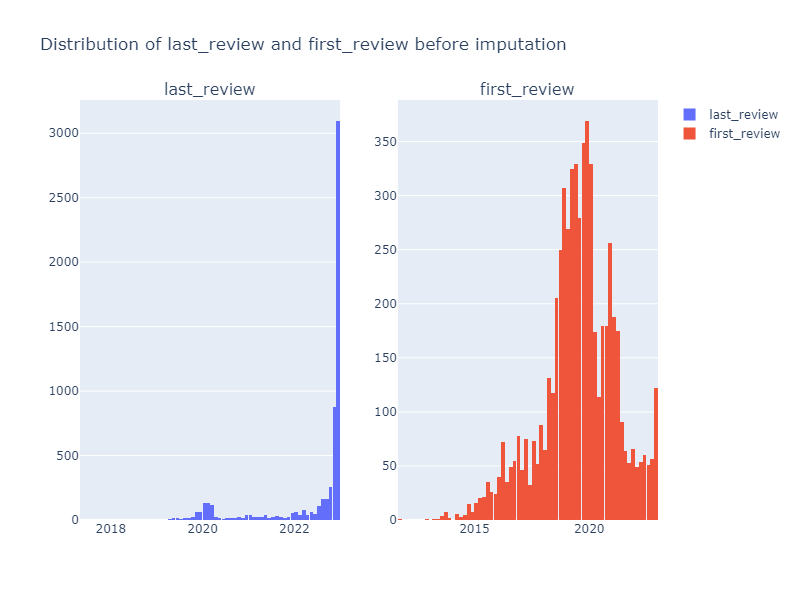

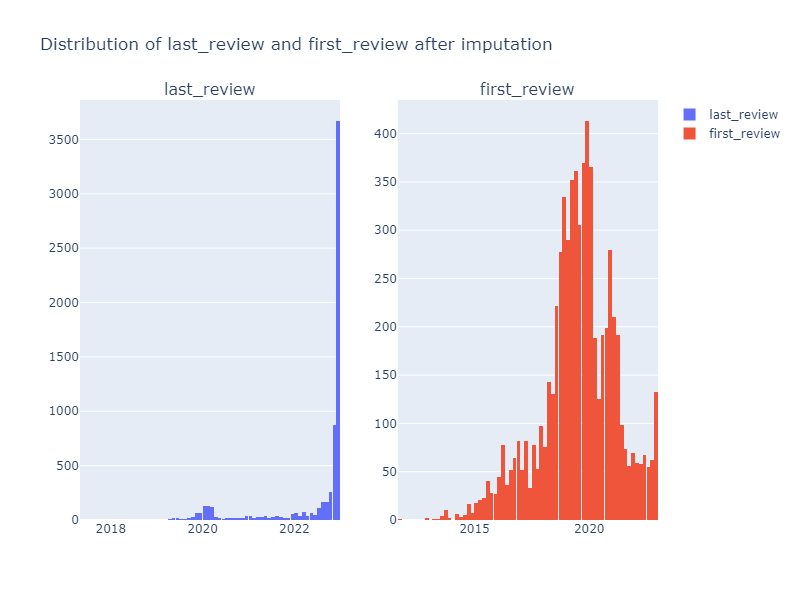

In [51]:
# convert last_review and first_review to datetime in order %d/%m/%Y
data['last_review'] = pd.to_datetime(data['last_review'], format='%d/%m/%Y')
data['first_review'] = pd.to_datetime(data['first_review'], format='%d/%m/%Y')

# print distribution of last_review and first_review before imputation
multi_histogram(data, ['last_review', 'first_review'], cols_per_row=2,title = 'Distribution of last_review and first_review before imputation',figsize=(600, 800))

# fill missing values with min or max values of the column
data['last_review'] = data['last_review'].fillna(data['last_review'].max())

data = random_imputation(data, 'first_review') # fill missing values with random values from the distribution of the column

# print distribution of last_review and first_review after imputation
multi_histogram(data, ['last_review', 'first_review'], cols_per_row=2,title = 'Distribution of last_review and first_review after imputation',figsize=(600, 800))

-  ####  Method 4: Use Mode for categorical variables

In [52]:
# fill license na with mode 
data['license'] = data['license'].fillna(data['license'].mode()[0])

# mode of host_since to impute missing values
m = data['host_response_time'].mode()[0]
# calc the probability for the mode 
prob_within_an_hour = data['host_response_time'].value_counts()[m] / data['host_response_time'].value_counts().sum() # 0.89
print(f"Probability for '{m}' is {prob_within_an_hour}")
m = data['host_response_time'].mode()[0]
data['host_response_time'] = data['host_response_time'].fillna(m)

# find the mode of bathrooms_text
bathrooms_mode = data['bathrooms_text'].mode()[0]
data['bathrooms_text'] = data['bathrooms_text'].fillna(bathrooms_mode)

Probability for 'within an hour' is 0.8816731770833334


-  ####  Method 5: Use Median

In [53]:

# 4. fill missing values to columns with small number of missing values with the median
for column in ['minimum_nights_avg_ntm', 'minimum_minimum_nights', 'maximum_maximum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights_avg_ntm','host_is_superhost']:
    data[column].fillna(data[column].median(), inplace=True)


In [54]:
# Check if there are any missing values left
assert data.isnull().sum().sum() == 0, "There are still missing values in the dataset"

Summerize methods:

1. Method 1: Fill Missing values by 'host_id' grouping: This method fills missing values in specific columns by using either the mean/mode of other listings from the same host (if available), or the overall mean/mode value of all listings when no additional information from the same host is available.
1. Method 2: MICE (Multivariate Imputation by Chained Equations) Algorithm: Best for multivariate data where features have linear relationships. It uses other features within the same record to estimate the missing value.

2. Method 3: Imputation for Dates: By using the MCAR for('first_review') and latest date ('last_review'), this method ensures imputed values stay within the observed date range and maintain the distrbution of the dates.

3. Method 4: Mode or Median Imputation: Mode (most frequent value) imputation is used for categorical features like 'license', 'host_response_time', and 'bathrooms_text'. This is effective when a certain category significantly dominates the others.

4. Method 5: Median Imputation: For numerical features with small missing values, median imputation is applied. The median is less sensitive to outliers and skewed data, making it an appropriate choice for such data

## 3.3. Transformations 

handle skewness features - ensure normal distrbution

In [55]:
# Method 1 - apply log transformation to highly skewed features
from scipy.stats import skew

# Check for skewness in these columns
skewed_cols = data[numerical_columns].apply(lambda x: skew(x)).sort_values(ascending=False)

# Filter to find highly skewed features
high_skew = skewed_cols[skewed_cols > 0.5]
skew_index = high_skew.index

data_transformed = data.copy()
for i in skew_index:
    data_transformed[i] = np.log1p(data_transformed[i])

skewed_cols = data_transformed[numerical_columns].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_cols[skewed_cols > 0.5]
print(high_skew)

# Method 2 - apply boxcox transformation to highly skewed features
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

data_transformed = data.copy()
for i in skew_index:
    data_transformed[i] = boxcox1p(data_transformed[i], boxcox_normmax(data_transformed[i] + 1))

# check skewness again
skewed_cols = data_transformed[numerical_columns].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_cols[skewed_cols > 0.5]
print(high_skew)

# Method 3 - apply yeo-johnson transformation to highly skewed features
from sklearn.preprocessing import PowerTransformer
data_transformed = data.copy()
pt = PowerTransformer()
for i in skew_index:
    data_transformed[i] = pt.fit_transform(data_transformed[i].values.reshape(-1, 1))
skewed_cols = data_transformed[numerical_columns].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_cols[skewed_cols > 0.5]
print(high_skew)


calculated_host_listings_count_shared_rooms     4.919523
minimum_minimum_nights                          3.333209
minimum_nights                                  3.107288
minimum_nights_avg_ntm                          2.883575
maximum_minimum_nights                          2.428406
bedrooms                                        2.231558
calculated_host_listings_count_private_rooms    1.386122
reviews_per_month                               1.018898
beds                                            0.944899
number_of_reviews_l30d                          0.826885
accommodates                                    0.507907
dtype: float64


calculated_host_listings_count_shared_rooms     3.934768
calculated_host_listings_count_private_rooms    1.148815
minimum_minimum_nights                          0.968038
number_of_reviews_l30d                          0.779378
minimum_nights                                  0.774607
minimum_nights_avg_ntm                          0.669503
maximum_minimum_nights                          0.610493
dtype: float64
calculated_host_listings_count_shared_rooms     3.751682
bedrooms                                        0.906947
calculated_host_listings_count_private_rooms    0.789936
minimum_minimum_nights                          0.631392
dtype: float64


Well choose The Yeo-Johnson transformation is chosen due to its effectiveness in reducing skewness in more features and its capability to handle both positive and negative data.

# 4. Feature Engineering - add new features

- ### New Date Features


In [56]:
def create_new_date_features(data):
    columns = data.columns
    # encode 'host_since' to the number of years, months, days and hours
    data['host_since_year'] = data['host_since'].dt.year
    data['host_since_month'] = data['host_since'].dt.month
    data['host_since_day'] = data['host_since'].dt.day
    # calculathe number of days, months and years between last_review and first_review
    data['days_between_last_first_review'] = (data['last_review'] - data['first_review']).dt.days
    data['months_between_last_first_review'] = (data['last_review'] - data['first_review']).dt.days / 30
    data['years_between_last_first_review'] = (data['last_review'] - data['first_review']).dt.days / 365

    # ---------------# calculate number of days, months and years between now and last_review, first_review and now
    # calculate number of days, months and years between now and last_review, first_review and now 
    data['days_between_now_last_review'] = (pd.to_datetime('now') - data['last_review']).dt.days
    data['months_between_now_last_review'] = (pd.to_datetime('now') - data['last_review']).dt.days / 30
    data['years_between_now_last_review'] = (pd.to_datetime('now') - data['last_review']).dt.days / 365


    data['days_between_now_first_review'] = (pd.to_datetime('now') - data['first_review']).dt.days
    data['months_between_now_first_review'] = (pd.to_datetime('now') - data['first_review']).dt.days / 30
    data['years_between_now_first_review'] = (pd.to_datetime('now') - data['first_review']).dt.days / 365

    # calculate number of days, months and years between now and last_review, first_review and host_since
    data['days_between_host_since_last_review'] = (data['last_review'] - data['host_since']).dt.days
    data['months_between_host_since_last_review'] = (data['last_review'] - data['host_since']).dt.days / 30
    data['years_between_host_since_last_review'] = (data['last_review'] - data['host_since']).dt.days / 365
    data['days_between_host_since_first_review'] = (data['first_review'] - data['host_since']).dt.days
    data['months_between_host_since_first_review'] = (data['first_review'] - data['host_since']).dt.days / 30


    # calculate number of days, months and years between now and host_since
    data['days_between_now_host_since'] = (pd.to_datetime('now') - data['host_since']).dt.days
    data['months_between_now_host_since'] = (pd.to_datetime('now') - data['host_since']).dt.days / 30
    data['years_between_now_host_since'] = (pd.to_datetime('now') - data['host_since']).dt.days / 365
    new_features_columns = [col for col in data.columns if col not in columns]
    return data, new_features_columns

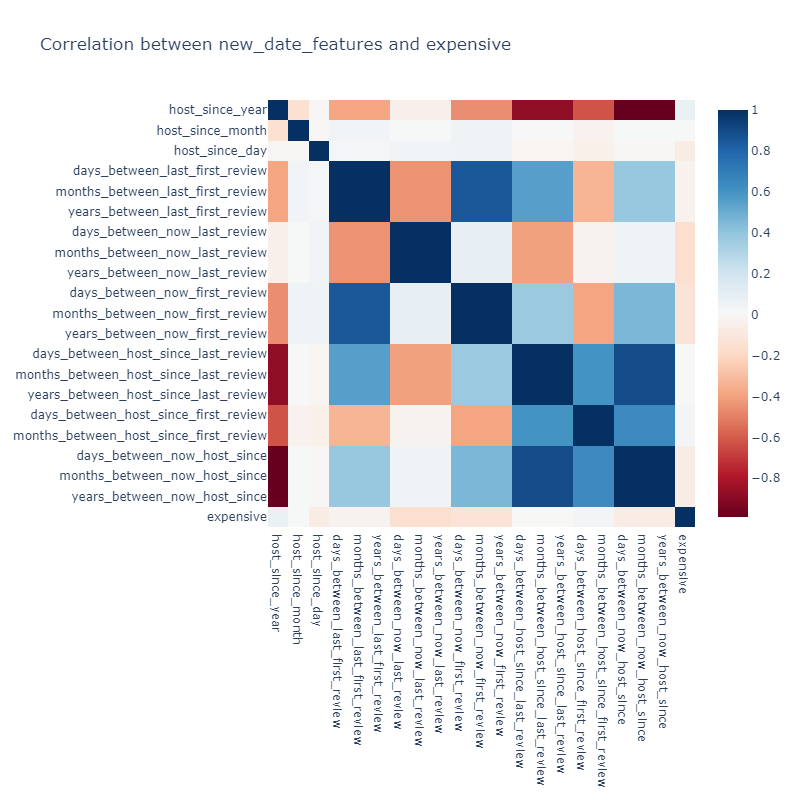

expensive                                 1.000000
host_since_year                           0.073493
days_between_host_since_first_review      0.033842
months_between_host_since_first_review    0.033842
host_since_month                          0.008443
months_between_host_since_last_review     0.003089
days_between_host_since_last_review       0.003089
years_between_host_since_last_review      0.003089
years_between_last_first_review          -0.031600
days_between_last_first_review           -0.031600
months_between_last_first_review         -0.031600
host_since_day                           -0.072386
months_between_now_host_since            -0.074739
years_between_now_host_since             -0.074739
days_between_now_host_since              -0.074739
years_between_now_first_review           -0.128776
months_between_now_first_review          -0.128776
days_between_now_first_review            -0.128776
years_between_now_last_review            -0.160156
days_between_now_last_review   

In [57]:
data['host_since'] = pd.to_datetime(data['host_since'],format='%d/%m/%Y')
       
data, new_date_features = create_new_date_features(data)
# plot heatmap correlation using plotly express 
new_date_features.append('expensive')
fig = px.imshow(data[new_date_features].corr(), color_continuous_scale='RdBu', title='Correlation between new_date_features and expensive', width=800, height=800)
fig.show()

# print correlation values between new_date_features and 'expensive' 
print(data[new_date_features].corr()['expensive'].sort_values(ascending=False))


Its make sense to explore how we can use those date features ['host_since', 'last_review', 'first_review'] to create new features that will help us to predict the 'expensive' column.

but from the heatmap values we can see that there is not strong correlation between the new date features and 'expensive' column -
 meaning we dont have strong linear relationship between the new date features and 'expensive' column.

- ### New 'frequncy' Features

    Now we explore how new features like:

        1. 'frequncy of reviews' = 'number_of_reviews' / 'days_between_last_first_review' 
    
        2. 'average number of reviews per month' = 'number_of_reviews' / 'months_between_last_first_review'
    
        4. 'availablity_ratio' = 'availability_365' / 365

        5. 'short_term_availability_ratio' = 'availability_30' / 30

        6. 'change_in_availability' = 'availability_30' - 'availability_365'

        8. 'change_in_availability_ratio' = 'short_term_availability_ratio' - 'availablity_ratio'

        9. 'change_in_availability_short_term' = 'availability_30' - 'availability_60'

        10. 'change_in_availability_long_term' = 'availability_60' - 'availability_365'

        11. 'change_in_availability_ratio_short_term' = 'short_term_availability_ratio' - 'availability_60'

        13. 'avarge_stay' = 'minimum_nights' + 'maximum_nights' / 2

        14. 'Nights_range' = 'maximum_nights' - 'minimum_nights'
        
        15. 'Avarge_nights' = 'minimun_nights_avg_ntm' + 'maximum_nights_avg_ntm' / 2



In [58]:
def create_new_frequncy_features(data):
    data = data.copy()
    columns = data.columns
    data['frequency_of_reviews'] = data['number_of_reviews'] / data['reviews_per_month']
    #  Availability Ratio
    data['availability_ratio'] = data['availability_365'] / 365

    # Short-term Availability Ratio
    data['short_term_availability_ratio'] = data['availability_30'] / 30

    # Change in Availability
    data['change_in_availability_30_60'] = data['availability_60'] - data['availability_30']
    data['change_in_availability_60_90'] = data['availability_90'] - data['availability_60']
    data['change_in_availability_90_30'] = data['availability_90'] - data['availability_30']
    data['change_in_availability_90_365'] = data['availability_365'] - data['availability_90']
    data['change_in_availability_30_365'] = data['availability_365'] - data['availability_30']
    data['change_in_availability_60_365'] = data['availability_365'] - data['availability_60']
    # Average Stay
    data['average_stay'] = (data['minimum_nights'] + data['maximum_nights']) / 2

    # Nights Range
    data['nights_range'] = data['maximum_nights'] - data['minimum_nights']

    # Difference between Min and Max Nights
    data['diff_max_nights'] = data['maximum_maximum_nights'] - data['minimum_maximum_nights']
    data['diff_min_nights'] = data['maximum_minimum_nights'] - data['minimum_minimum_nights']

    # Average Nights
    data['avg_nights'] = (data['minimum_nights_avg_ntm'] + data['maximum_nights_avg_ntm']) / 2
    new_features_columns = [col for col in data.columns if col not in columns]
    return data, new_features_columns

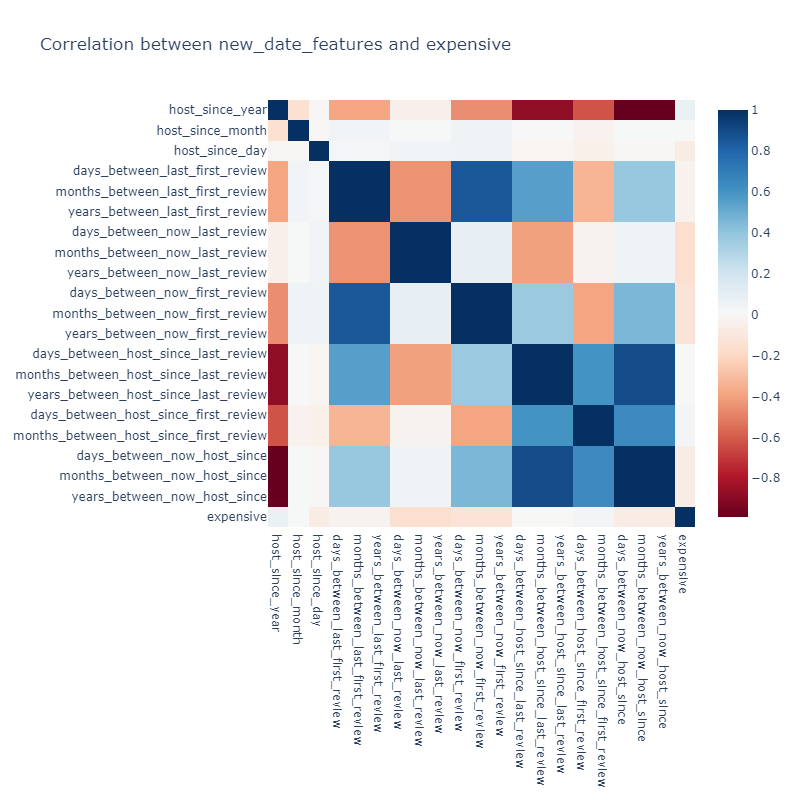

expensive                        1.000000
change_in_availability_60_90     0.200346
change_in_availability_90_30     0.199298
change_in_availability_30_60     0.171632
short_term_availability_ratio    0.141988
availability_ratio               0.103874
change_in_availability_30_365    0.093112
diff_min_nights                  0.077126
change_in_availability_60_365    0.075599
diff_max_nights                  0.067323
change_in_availability_90_365    0.052450
nights_range                    -0.041325
average_stay                    -0.042829
avg_nights                      -0.067410
frequency_of_reviews            -0.098165
Name: expensive, dtype: float64


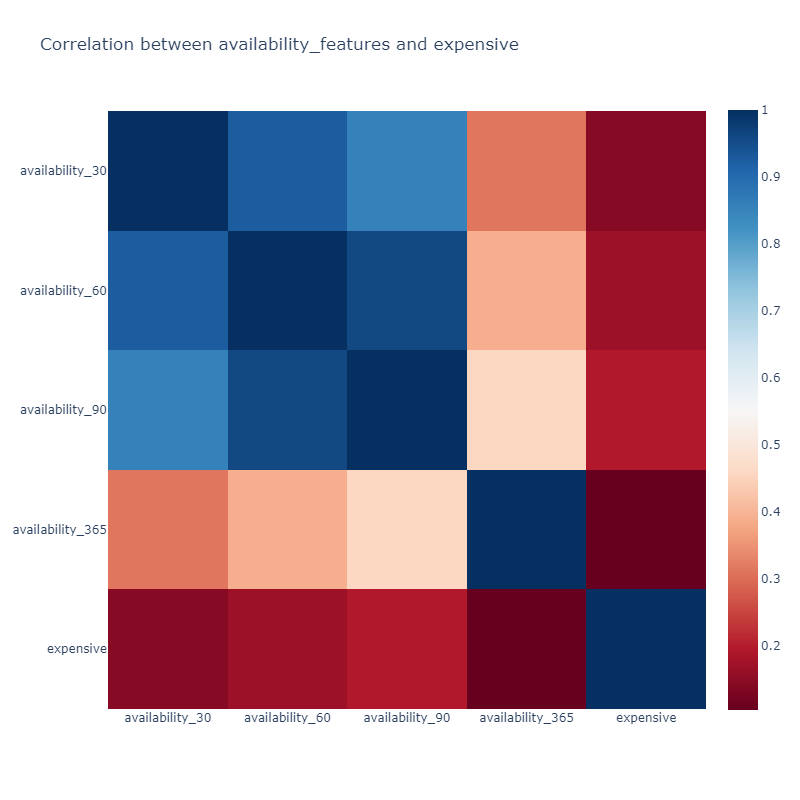

availability_90     0.193811
availability_60     0.168539
availability_30     0.141988
availability_365    0.103874
Name: expensive, dtype: float64


In [59]:

data, new_features = create_new_frequncy_features(data)

# plot heatmap correlation using plotly express 

new_features.append('expensive')
fig = px.imshow(data[new_date_features].corr(), color_continuous_scale='RdBu', title='Correlation between new_date_features and expensive', width=800, height=800)
fig.show()


# print correlation values between new_date_features and 'expensive' 
print(data[new_features].corr()['expensive'].sort_values(ascending=False))
 
# check correlation between avaliblity features and expensive
availability_features = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
availability_features.append('expensive')
# add the correaltion values to the heatmap
fig = px.imshow(data[availability_features].corr(), color_continuous_scale='RdBu', title='Correlation between availability_features and expensive', width=800, height=800)
# add values to the h
fig.show()
print(data[availability_features].corr()['expensive'].sort_values(ascending=False)[1:])




We can see that some of those features are with some correlation to the target table that is better to from the corrleation that was before the feature engenerring step like in change_in_availability_60_90 vs availability_60

### Cluster License feature

In [60]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

def cluster_text(text,plot=False):
    vectorizer = TfidfVectorizer(stop_words='english') #random_state=2023

    
    X = vectorizer.fit_transform(text)

    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = range(2,15)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=2023)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    if plot:
        plt.plot(K, Sum_of_squared_distances, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum_of_squared_distances')
        plt.title('Elbow Method For Optimal k')
        plt.show()
    
    true_k = 11 # chosen after seeing the elbow plot
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10, random_state=2023)
    model.fit(X)

    labels=model.labels_
    # labels as object
    labels = labels.astype('object')
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
    
    return clusters

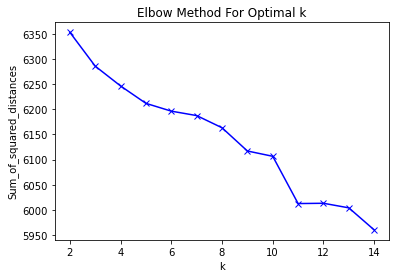

number of clusters for liscnse:  11


In [61]:

license_count = data['license'].value_counts()

license_list = data['license'].tolist()


data['license_clusters'] = cluster_text(license_list,plot=True)['cluster'].astype('object')
# if null in license_clustres complete with mode
data['license_clusters'] = data['license_clusters'].fillna(data['license_clusters'].mode()[0])
print("number of clusters for liscnse: ", data['license_clusters'].nunique())

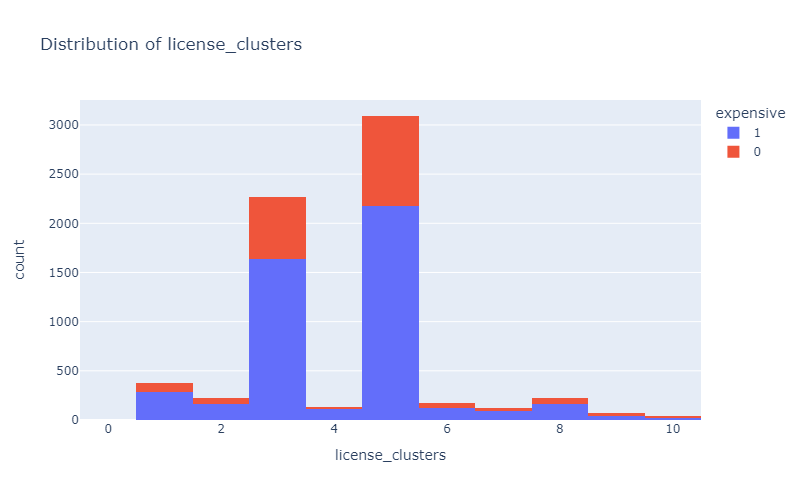

Chi-Square statistic for license_clusters vs expensive: 20.886162573125887
P-value: 0.021901496263237313
Reject null hypothesis: the variables is depedent - means it can be used as good predictor for target variable


True

In [62]:
# check correlation between license_clusters and expensive
# plot distribution of license_clusters 
fig = px.histogram(data, x="license_clusters", color="expensive", title='Distribution of license_clusters', width=800, height=500)
fig.show()
perform_chi2_test(data, 'license_clusters', 'expensive')

### New Location Features 

Use longtitude and latitude to in order to cluster the the difrent listings by location - using kmeans algorithm
We expect that expensive listings will be located in 'expensive' areas and vice versa

In [63]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

X = data[['latitude', 'longitude']]


def get_best_k(X, max_clusters):
    best_k = 2
    best_score = -1
    for i in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        preds = kmeans.fit_predict(X)
        score = silhouette_score(X, preds)
        if score > best_score:
            best_k = i
            best_score = score
    return best_k

In [64]:
kmeans = KMeans(n_clusters=get_best_k(X,10), init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

# Add cluster info to the original DataFrame
data['location_cluster'] = pred_y.astype('object')

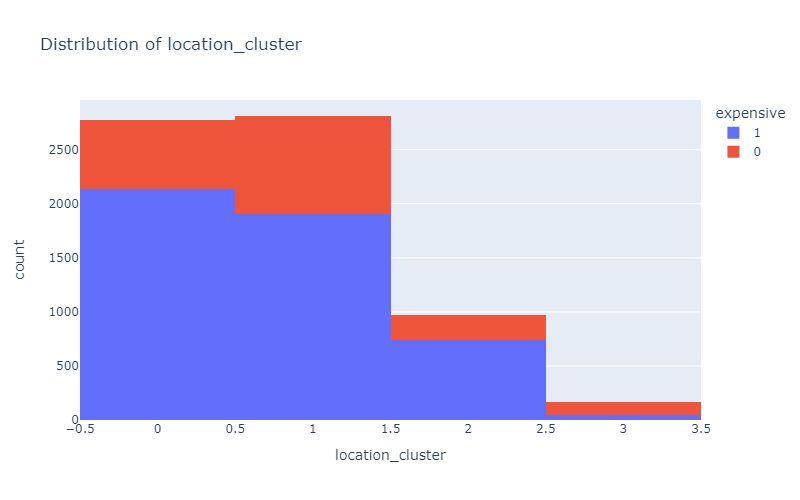

Chi-Square statistic for location_cluster vs expensive: 253.71436264819278
P-value: 1.029059504108981e-54
Reject null hypothesis: the variables is depedent - means it can be used as good predictor for target variable


True

In [65]:
# plot distribution of location_cluster 
fig = px.histogram(data, x="location_cluster", color="expensive", title='Distribution of location_cluster', width=800, height=500)
fig.show()
# check correlation between location_cluster and expensive
perform_chi2_test(data, 'location_cluster', 'expensive')


Number of bathrooms as new feature and number of bedrooms_per_accomodat

In [66]:
def manipulate_bathrooms_text(value):
    if isinstance(value, str):
        if 'half' in value.lower():
            return 0.5
        elif any(char.isdigit() for char in value):
            digits = ''.join(filter(lambda char: char.isdigit() or char == '.', value))
            return float(digits)
    return np.nan

In [67]:

data['bathrooms_num'] = data['bathrooms_text'].apply(manipulate_bathrooms_text)

data['bedrooms_per_accommodat'] = data['bathrooms_num'] / data['accommodates']
mask = np.isinf(data['bedrooms_per_accommodat'])

# Use the mask to replace infinite values with corresponding 'bathrooms_text' values
data.loc[mask, 'bedrooms_per_accommodat'] = data.loc[mask, 'bathrooms_num']

In [68]:
# remove unwanted columns from the data 
data.columns
columns_to_removs = ['id','host_id','host_since','latitude','longitude','amenities','license','last_review','first_review','host_identity_verified','host_has_profile_pic','bathrooms_text']
# check if all columns are in the data then remove them
if all(elem in data.columns for elem in columns_to_removs):
    data.drop(columns_to_removs, axis=1, inplace=True)
    print("Columns removed successfully")



Columns removed successfully


# 5. Build, Evaluate & Compare diffrent models performance

In [69]:
X = pd.read_csv('data/train.csv')

### 5.1 Define one preprocess functions with all the steps we do in the above analysis

In [70]:
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, Normalizer
from functools import wraps
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# ---------------Helper functions-----------------#

# define the power transformer
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')

# define the column transformer for categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

def fill_na_with_host_specific_values(data, host_cols):
    """
    Fills the missing values in the host_cols with the mean (for numerical columns) or mode 
    (for categorical columns) specific to each host_id. If the host specific mean or mode 
    cannot be computed, it is filled with the general mean or mode of the entire dataset.
    """
    # General mean and mode for each column
    general_values = {
        col: data[col].mean() if data[col].dtype in ['int64', 'float64'] else data[col].mode()[0] 
        for col in host_cols
    }

    # Find the host_ids that has na values for each col and fill with their mean or mode value 
    for col in host_cols:
        # Find the host_ids that has na values for col
        host_ids_na = data[data[col].isnull()]['host_id'].unique()

        for host_id in host_ids_na:
            # If column is numeric, fill with mean. Otherwise, fill with mode.
            if data[col].dtype in ['int64', 'float64']:
                mean_val = data[(data['host_id'] == host_id) & (data[col].notnull())][col].mean()
                fill_val = mean_val if not np.isnan(mean_val) else general_values[col]
            else:
                mode_val = data[(data['host_id'] == host_id) & (data[col].notnull())][col].mode()
                fill_val = mode_val[0] if not mode_val.empty else general_values[col]
            
            # Fill the missing values
            data.loc[(data['host_id'] == host_id) & (data[col].isnull()), col] = fill_val

    return data

def impute_missing_values_mice_train_test(train_data, test_data, columns, random_state=2023, max_iter=20):
    """
    Use IterativeImputer to impute missing values in train and test data.

    """
    # Define imputer
    imputer = IterativeImputer(random_state=random_state, max_iter=max_iter)
    
    # Fit on the training dataset
    imputer.fit(train_data.loc[:, columns])
    
    # Transform the training and test datasets
    train_data[columns] = imputer.transform(train_data.loc[:, columns])
    test_data[columns] = imputer.transform(test_data.loc[:, columns])

    return train_data, test_data


def create_new_features(data):
    data, _ = create_new_date_features(data)
    data, _ = create_new_frequncy_features(data)
    data['license_cluster'] = cluster_text(license_list)['cluster'].astype('object')
    data['license_cluster'] = data['license_cluster'].fillna(data['license_cluster'].mode()[0]) # fill missing values with mode
    # Add cluster info to the original DataFrame
    location_data = data[['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=get_best_k(location_data,10), init='k-means++', max_iter=300, n_init=10, random_state=2023)
    pred_y = kmeans.fit_predict(location_data)
    data['location_cluster'] = pred_y.astype('object')
    data['bathrooms_num'] = data['bathrooms_text'].apply(manipulate_bathrooms_text)
    data['bedrooms_per_accommodat'] = data['bathrooms_num'] / data['accommodates']
    data['bathrooms_per_accommodat'] = np.where(data['accommodates'] == 0, 0, data['bathrooms_num'] / data['accommodates'])
    # fill inf values
    
    data['num_amenities'] = data['amenities'].str.split(',').apply(len)
    mask = np.isinf(data['bedrooms_per_accommodat'])
    # Use the mask to replace infinite values with corresponding 'bathrooms_text' values
    data.loc[mask, 'bedrooms_per_accommodat'] = data.loc[mask, 'bathrooms_num']
    return data

def cap_outliers(X_train, X_test, columns):
    quantiles = {}
    for column in columns:
        quantiles[column] = X_train[column].quantile(0.99)
    for column, quantile in quantiles.items():
        X_train.loc[X_train[column] > quantile, column] = quantile # cap values in train set
        X_test.loc[X_test[column] > quantile, column] = quantile # cap values in test set
    return X_train, X_test

def handle_missing_values(X_train, X_test, columns):
    # Fill missing values in train and test sets
    X_train = fill_na_with_host_specific_values(X_train, columns)
    X_test = fill_na_with_host_specific_values(X_test, columns)

    # Impute missing values in train and test sets
    mice_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d', 'bedrooms', 'beds']
    X_train, X_test = impute_missing_values_mice_train_test(X_train, X_test, mice_cols, random_state=2023, max_iter=20)

    # Random imputation in train and test sets
    X_train = random_imputation(X_train, 'first_review')
    X_test = random_imputation(X_test, 'first_review')

    # Fill missing values in specific columns of train and test sets
    for column in ['bathrooms_text','host_response_time']:
        X_train[column].fillna(X_train[column].mode()[0], inplace=True)
        X_test[column].fillna(X_train[column].mode()[0], inplace=True) # note: we use mode from train set

    # Another example of filling missing values
    for column in ['minimum_nights_avg_ntm', 'minimum_minimum_nights', 'maximum_maximum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights_avg_ntm','host_is_superhost']:
        X_train[column].fillna(X_train[column].median(), inplace=True)
        X_test[column].fillna(X_train[column].median(), inplace=True) # note: we use median from train set

    return X_train, X_test

def standardize(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

def normalize(X):
    normalizer = Normalizer()
    return normalizer.fit_transform(X)

# Convert Categorical variables
def create_dummy_df(df, cat_cols, categories_dict, dummy_na):
    for col in cat_cols:
        try:
            # Get full list of categories for this column
            categories = categories_dict[col]

            # Create dummy variables, ensuring all categories are included
            dummies = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)
            dummies = dummies.reindex(columns=[col+'_'+str(category) for category in categories], fill_value=0)

            # Add dummy variables to df and drop original column
            df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
        except:
            continue
    return df


def preprocess_function(X_train, X_test,transform_numeric='yeo-johnson', do_feature_eng=True, do_handle_missing=True, remove_missing=False,do_balance = False):
    print('Total number of missing values before imputation in train set: ', X_train.isnull().sum().sum())
    y_train = X_train['expensive']
    X_train = X_train.drop('expensive', axis=1)

    # transform columns to datetime
    date_columns = ['last_review', 'first_review','host_since']  # Update this list based on your DataFrame
    for column in date_columns:
        X_train[column] = pd.to_datetime(X_train[column], format = '%d/%m/%Y')
        X_test[column] = pd.to_datetime(X_test[column], format = '%d/%m/%Y')

    # Replace '%' and convert to numeric
    percentage_columns = ['host_acceptance_rate', 'host_response_rate']
    for column in percentage_columns:
        X_train[column] = X_train[column].str.replace('%', '').astype(float)
        X_test[column] = X_test[column].str.replace('%', '').astype(float)

    # Handle binary columns
    binary_columns = X_train.columns[(X_train.nunique() == 2) & (X_train.dtypes == 'object')].tolist()
    X_train[binary_columns] = X_train[binary_columns].apply(lambda x: x.map({'t': 1, 'f': 0}))
    X_test[binary_columns] = X_test[binary_columns].apply(lambda x: x.map({'t': 1, 'f': 0}))

    # Cap outliers
    X_train, X_test = cap_outliers(X_train, X_test, ['minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm'])

    # Handle missing values
    if do_handle_missing:
        X_train, X_test = handle_missing_values(X_train, X_test, ['host_response_rate', 'host_acceptance_rate', 'license', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d', 'bedrooms', 'beds', 'first_review', 'last_review', 'bathrooms_text','host_response_time', 'minimum_nights_avg_ntm', 'minimum_minimum_nights', 'maximum_maximum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights_avg_ntm','host_is_superhost'])
    else:
        # Filling missing categorical & binary columns with mode and numeric columns with mean
        for col in X_train.columns:
            if X_train[col].dtype == 'object':
                X_train[col].fillna(X_train[col].mode()[0], inplace=True)
                X_test[col].fillna(X_train[col].mode()[0], inplace=True) # using mode from training set
            else:
                X_train[col].fillna(X_train[col].mean(), inplace=True)
                X_test[col].fillna(X_train[col].mean(), inplace=True) # using mean from training set

    print('Total number of missing values after imputation in train set: ', X_train.isnull().sum().sum())

    # Feature engineering
    if do_feature_eng:
        X_train = create_new_features(X_train)
        X_test = create_new_features(X_test)

    # Remove unnecessary columns
    columns_to_remove = ['id','host_id','host_since','latitude','longitude','amenities','license','last_review','first_review','bathrooms_text', 'amenities']
    X_train = X_train.drop(columns_to_remove, axis=1)
    X_test = X_test.drop(columns_to_remove, axis=1)

    # Drop rows with missing values in train and test sets
    if remove_missing:
        X_train = X_train.dropna()
        X_test = X_test.dropna()

    # Print all columns with infinite values in train set or test set
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    print('Infinite values in train set: ', numeric_cols[X_train[numeric_cols].apply(lambda x:np.any(np.isinf(x)))])
    numeric_cols_test = X_test.select_dtypes(include=[np.number]).columns
    print('Infinite values in test set: ', numeric_cols_test[X_test[numeric_cols_test].apply(lambda x:np.any(np.isinf(x)))])

    if transform_numeric:
        numeric_cols = X_train.select_dtypes(include=[np.number]).columns
        if transform_numeric == 'normalize':
            X_train[numeric_cols] = normalize(X_train[numeric_cols])
            X_test[numeric_cols] = normalize(X_test[numeric_cols])
        elif transform_numeric == 'standardize':
            X_train[numeric_cols] = standardize(X_train[numeric_cols])
            X_test[numeric_cols] = standardize(X_test[numeric_cols])
        elif transform_numeric == 'yeo-johnson':
            X_train[numeric_cols] = yeo_johnson_transformer.fit_transform(normalize(X_train[numeric_cols]))
            X_test[numeric_cols] = yeo_johnson_transformer.transform(normalize(X_test[numeric_cols]))

    # Encoding categorical features
    
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    # Combine train and test data to get full list of categories
    full_data = pd.concat([X_train, X_test])
    # Create dictionary mapping each categorical column to its full list of categories
    categories_dict = {col: full_data[col].dropna().unique() for col in categorical_cols}
    
    X_train = create_dummy_df(X_train, categorical_cols, categories_dict, dummy_na=False)
    X_test = create_dummy_df(X_test, categorical_cols, categories_dict, dummy_na=False)

    # Get column names after one-hot encoding
    column_names = X_train.columns.tolist()

    
    if do_balance:
        smote = SMOTE(random_state=2023)
        X_train, y_train = smote.fit_resample(X_train, y_train)


    return X_train,y_train, X_test,column_names

    

### 5.2 Run Cross-Validation on diffrent models to find the model with the best auc-roc score

#### 1. First Model - Using feature engineering and preprocess from the analysis without PCA 

In [71]:

X_train = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/test.csv')
# Preprocess the data
X_train, y_train, X_test,col_names = preprocess_function(X_train, X_test)
# Perform feature selection
selector = SelectFromModel(estimator=LogisticRegression())
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


Total number of missing values before imputation in train set:  8362


Total number of missing values after imputation in train set:  0
Infinite values in train set:  Index([], dtype='object')
Infinite values in test set:  Index([], dtype='object')


In [72]:
# Get boolean mask for selected features
mask = selector.get_support()

# Get column names of selected features
selected_columns = [col for col, bool in zip(col_names, mask) if bool]

print("Selected columns: ", selected_columns)


Selected columns:  ['host_response_rate', 'accommodates', 'minimum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm', 'has_availability', 'availability_60', 'availability_365', 'review_scores_rating', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'frequency_of_reviews', 'availability_ratio', 'change_in_availability_60_90', 'change_in_availability_90_30', 'change_in_availability_90_365', 'change_in_availability_60_365', 'diff_min_nights', 'avg_nights', 'num_amenities', 'host_response_time_within a few hours', 'host_response_time_within a day', "host_verifications_['phone', 'work_email']", "host_verifications_['email', 'work_email']", 'property_type_Private room in home', 'property_type_Entire home', 'property_type_Shared room in rental unit', 'property_type_Entire townhouse', 'property_type_Private room in villa', 'property_type_Room in aparthotel', 'property_type_Enti

In [73]:

def custom_cross_val_score(model, X_train, y_train, cv=20):
    kf = StratifiedKFold(n_splits=cv, random_state=2023, shuffle=True)
    scores = []

    for train_index, test_index in kf.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

        model.fit(X_train_cv, y_train_cv)
        y_pred_proba_cv = model.predict_proba(X_test_cv)[:, 1]  # keep probabilities for the positive outcome only
        score = roc_auc_score(y_test_cv, y_pred_proba_cv)
        scores.append(score)
    
    print("Cross-validation scores: ", scores)
    print("Mean cross-validation ROC AUC score: ", np.mean(scores))

    
    return scores,np.mean(scores) # return mean of CV scores and test score


model = myLogisticRegression()
custom_cross_val_score(model, X_train_selected, y_train, cv=5)


Cross-validation scores:  [0.8220327090192692, 0.8286516475492216, 0.80178213926769, 0.8087878273475118, 0.7840165550926901]
Mean cross-validation ROC AUC score:  0.8090541756552765


([0.8220327090192692,
  0.8286516475492216,
  0.80178213926769,
  0.8087878273475118,
  0.7840165550926901],
 0.8090541756552765)

**PCA Scree plot on processed data**

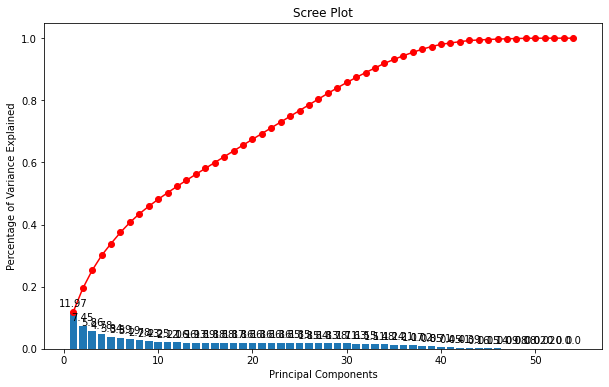

In [74]:
pca_2d = PCA(n_components=2) 
pca_2d.fit(X_train_selected)
X_train_2d = pca_2d.transform(X_train_selected)
pca_2d.plot_scree()

From the scree plot we can see that the first 2 components explain less than 20% of the variance and the first 3 components explain slightly above 20% of the data

#### 2. Second Model: With PCA k=2

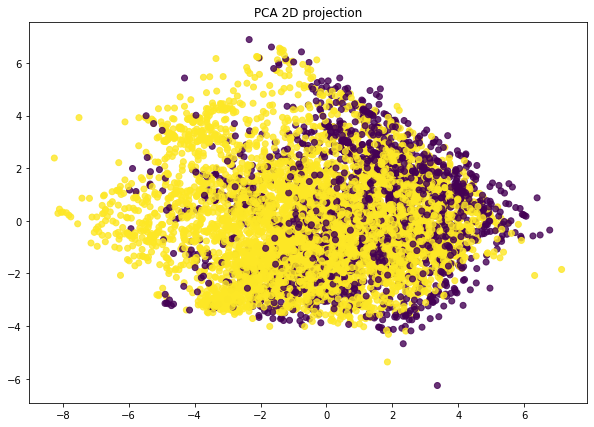

Cross-validation scores:  [0.6645382414853997, 0.6602995740002748, 0.6436071749023919, 0.6532319125259008, 0.6089129506859233]
Mean cross-validation ROC AUC score:  0.6461179707199782


([0.6645382414853997,
  0.6602995740002748,
  0.6436071749023919,
  0.6532319125259008,
  0.6089129506859233],
 0.6461179707199782)

In [75]:
pca_2d = PCA(n_components=2) 
pca_2d.fit(X_train_selected)
X_train_2d = pca_2d.transform(X_train_selected)

# 2D PCA projection plot
plt.figure(figsize=(10, 7))
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, alpha=0.8)
plt.title('PCA 2D projection')
plt.show()

model = myLogisticRegression()
custom_cross_val_score(model, X_train_2d, y_train, cv=5)  # use X_train_3d for 3D PCA data


#### 3. Third Model: PCA k=3

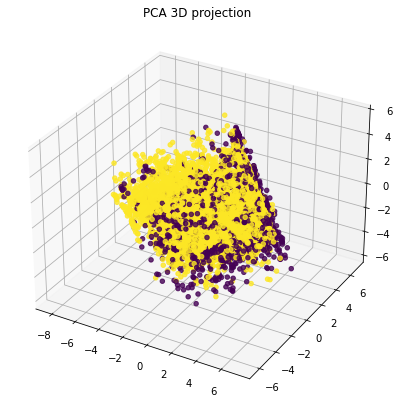

Cross-validation scores:  [0.6627516597398391, 0.6635168015261622, 0.647759392337394, 0.6541184015175399, 0.6069056997282242]
Mean cross-validation ROC AUC score:  0.6470103909698318


In [76]:
pca_3d = PCA(n_components=3) 
pca_3d.fit(X_train_selected)
X_train_3d = pca_3d.transform(X_train_selected)

# 3D PCA projection plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
ax.scatter3D(X_train_3d[:, 0], X_train_3d[:, 1], X_train_3d[:, 2], c=y_train, alpha=0.8)
plt.title('PCA 3D projection')
plt.show()

model = myLogisticRegression()
scores = custom_cross_val_score(model, X_train_3d, y_train, cv=5)  # use X_train_3d for 3D PCA data


#### 4. Forth Model: PCA k = 35

In [77]:
pca_35d = PCA(n_components=35) 
pca_35d.fit(X_train_selected)
X_train_35d = pca_35d.transform(X_train_selected)
model = myLogisticRegression()
scores = custom_cross_val_score(model, X_train_35d, y_train, cv=5)

Cross-validation scores:  [0.85787499325309, 0.8696995907061464, 0.8492214255497444, 0.8525949338097202, 0.8441854559404363]
Mean cross-validation ROC AUC score:  0.8547152798518274


#### 5. Third Model: With city feature calculated by api function

In [78]:
X_train = pd.read_csv('data/train.csv') # with the city column calculated by the api function
X_test = pd.read_csv('data/test.csv')
X_test_ids = X_test['id']
# Preprocess the data
X_train, y_train, X_test,col_names = preprocess_function(X_train, X_test)

# # Perform feature selection
selector = SelectFromModel(estimator=LogisticRegression())
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
# add to train and test the 'bedrooms_per_accommodates' and 'bathrooms_per_accommodates' columns
print(X_train_selected.shape)


Total number of missing values before imputation in train set:  8362
Total number of missing values after imputation in train set:  0
Infinite values in train set:  Index([], dtype='object')
Infinite values in test set:  Index([], dtype='object')
(6759, 54)


Cross-validation scores:  [0.8220327090192692, 0.8286516475492216, 0.80178213926769, 0.8087878273475118, 0.7840165550926901]
Mean cross-validation ROC AUC score:  0.8090541756552765


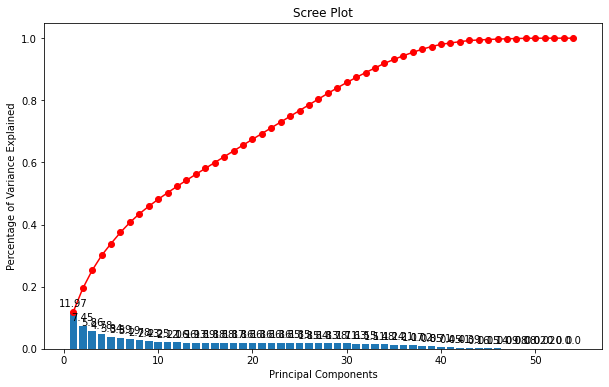

In [79]:
model = myLogisticRegression()
scores = custom_cross_val_score(model, X_train_selected, y_train, cv=5)
pca_2d = PCA(n_components=2) 
pca_2d.fit(X_train_selected)
X_train_2d = pca_2d.transform(X_train_selected)
pca_2d.plot_scree()

#### 6. Apply PCA for most variation in the data k=65

In [80]:
# using PCA to reduce the dimensionality of the data 
pca_50d= PCA(n_components=70) 
pca_50d.fit(X_train_selected)
X_train_50d = pca_50d.transform(X_train_selected)
model = myLogisticRegression()
scores = custom_cross_val_score(model, X_train_50d, y_train, cv=10)

Cross-validation scores:  [0.8531980352998326, 0.8675878447670966, 0.8713553192637772, 0.8751119987045932, 0.8374912290171102, 0.8661952825605872, 0.8432549931129477, 0.8692858987603305, 0.8550921143250688, 0.853576219116438]
Mean cross-validation ROC AUC score:  0.8592148934927781


#### 7. Seventh Model: Balancing the data 

In [81]:
X_train = pd.read_csv('data/train_data_new.csv') # with the city column calculated by the api function
X_test = pd.read_csv('data/test_data_new.csv')
X_test_ids = X_test['id']
# Preprocess the data
X_train, y_train, X_test,col_names = preprocess_function(X_train, X_test,do_balance=True)

# # Perform feature selection
selector = SelectFromModel(estimator=LogisticRegression())
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
model = myLogisticRegression()
scores = custom_cross_val_score(model, X_train_selected, y_train, cv=5)

Total number of missing values before imputation in train set:  8362
Total number of missing values after imputation in train set:  0
Infinite values in train set:  Index([], dtype='object')
Infinite values in test set:  Index([], dtype='object')
Cross-validation scores:  [0.822087815050057, 0.841750981456066, 0.8251237271835572, 0.8245081531607809, 0.8235528419178219]
Mean cross-validation ROC AUC score:  0.8274047037536565


#### 8. Eight model - LDA (Linear Discriminant Analysis)

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_selected, y_train)
model = myLogisticRegression()
scores = custom_cross_val_score(model, X_train_lda, y_train, cv=10)


Cross-validation scores:  [0.9275247103836752, 0.9332638962695291, 0.9465110334838545, 0.9424469625969157, 0.9322271449263014, 0.9490755729743545, 0.941100792366022, 0.9327511289085797, 0.932619067904916, 0.9394436397716622]
Mean cross-validation ROC AUC score:  0.937696394958581
